# Transformer NMT

- 이전까지의 우세한 `sequence transduction model`은 encoder와 decoder 구조를 사용하는 복잡한 RNN 내지 CNN
- 이 중 최상의 성능을 보인 모델은 `attention mechanism`을 사용하여 Encoder와 Decoder를 연결한 모델
- 본 Transformer는 `self-attention mechanism`에 초점을 둔, recurrence/convolution 연산을 완전 배제한 단일 network architecture를 제시

## 1. Introduction

#### Recurrent 연산의 한계
- recurrent model은 입력 및 출력 시퀀스의 symbol position을 따라 연산을 진행
- RNN의 순차적 성질(`inherently sequential nature`)은 메모리 제약으로 인해 batch화가 제한
- 긴 sequence length를 가진 학습 예제의 병렬화가 불가능
- `factorization tricks`, `contidional computation`등으로 해결하려 했지만 근본적인 해결책은 아님

#### Attention Mechanism
- 입력 또는 출력 시퀀스에서의 거리에 관계없이 dependencies를 모델링할 수 있도록 다양한 작업에서 필수적인 요소가 됨
- 예를 들어 sequence modeling, transduction model
- 그러나 이전에는 이를 RNN과 함께 사용하는 경우가 많았음

#### Transformer!
- Eschewing recurrence!
- input과 output 사이의 global dependencies를 도출하는 attention mechaism에 전면적으로 집중

Remark. `Transformer`는 `Transfer Learning`이 아님!

## 2. Background

#### Facebook의 convolutional seq2seq? 우린 차원이 달라!
- FaceBook이 발표한 논문 `Convolutional Sequence to Sequence Learning`의 모델 `ConvS2S`보다 우월해!
- 이는 input과 output position을 병렬로 하여 hidden representation을 계산
- 이 때 멀면 멀수록 연산의 수가 증가하고 `ConvS2S`는 linear하게, `ByteNet`은 log로 증가
- 이는 얼마나 떨어져있는지에 대한 dependencies를 학습하기 어렵게 만들고 연산의 수도 많다!
- 본 논문의 `multihead-attention`의 효과로 위의 연산과 동일한 역할을 수행하면서 연산의 수를 constant하게 줄였다

#### Self-Attention(Intra-Attention)
- sequence의 표현을 계산하기 위한 단일 sequence의 각 위치와 관련된 attention mechanism
- reading comprehension, abstractive summarization, teztual entailment, task-independent sentence representations 등에서 성공적으로 사용됨

#### MemN2N
- sequence-aligned reccurence대신 recurrent attention mechanism에 기반을 둠
- simple-language QA 및 language modeling tasks에서 좋은 성능을 제시함

#### 하지만 우리가 짱이라니까?
- 우리(구글)이 아는 한 `Transformer`는 sequence-aligned RNN 혹은 Convolution을 제외하고 input과 output의 표현을 계산하기 위해 self-attention을 사용한 첫 transduction model!

## 3. Model Architecture
- 대부분의 Neural Sequence Transduction Model들은 encoder-decoder 구조를 가짐
- Encoder는 $(x_1,\dots,x_n)$의 symbol representation의 입력 문장을 $z=(z_1,\dots,z_n)$의 continuous representation으로 매핑
- Decoder는 주어진 $z$에 대해 각 시점마다 한 symbol씩 생성하며 output sequence $(y_1,\dots,y_n)$ sentence를 만듦
- 각 스텝에서 모델은 다음 symbol을 생성할 때 이전에 생성된 symbol을 추가 input으로 활용하는 `auto-regressive`한 성질을 가짐

논문에서는 WMT2014 데이터로 실습을 진행하지만 본 리뷰에서는 AiHub에서 제공하는 `한국어-영어 대화체 말뭉치`로 실습을 진행

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import random
from collections import Counter

In [2]:
data_path = 'e:/aihub/2_대화체_200226.xlsx'
df = pd.read_excel(data_path)

In [3]:
df

대분류 소분류                            상황  Set Nr.  발화자  \
0       비즈니스  회의                       의견 교환하기        1  A-1   
1       비즈니스  회의                       의견 교환하기        1  B-1   
2       비즈니스  회의                       의견 교환하기        1  A-2   
3       비즈니스  회의                       의견 교환하기        1  B-2   
4       비즈니스  회의                       의견 교환하기        2  A-1   
...      ...  ..                           ...      ...  ...   
99995  여행/쇼핑  쇼핑  계산/포장/배달 (계산 장소 문의, 계산 오류 등)    24999  B-2   
99996  여행/쇼핑  쇼핑  계산/포장/배달 (계산 장소 문의, 계산 오류 등)    25000  A-1   
99997  여행/쇼핑  쇼핑  계산/포장/배달 (계산 장소 문의, 계산 오류 등)    25000  B-1   
99998  여행/쇼핑  쇼핑  계산/포장/배달 (계산 장소 문의, 계산 오류 등)    25000  A-2   
99999  여행/쇼핑  쇼핑  계산/포장/배달 (계산 장소 문의, 계산 오류 등)    25000  B-2   

                                             원문  \
0                   이번 신제품 출시에 대한 시장의 반응은 어떤가요?   
1                    판매량이 지난번 제품보다 빠르게 늘고 있습니다.   
2                  그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.   
3                   네, 제가 연락해서 주문량을 2배로 늘리겠습니다.   
4                   지난 회의 마지막에 논의했던 안건을 다시 볼까요?   
...                                         ...   
99995        저희가 가격표 배치를 잘못해서 혼동을 드렸나 봐요, 죄송해요.   
99996                 백화점 포인트로 계산하고 싶은데, 가능한가요?   
99997                 네, 물론이죠, 전화번호 입력해주시면 됩니다.   
99998              입력했어요, 전액 백화점 포인트로 결제하고 싶어요.   
99999  죄송하지만 포인트 제외한 차액 15,000원은 따로 결제해주셔야 합니다.   

                                                     번역문  
0      How is the market's reaction to the newly rele...  
1      The sales increase is faster than the previous...  
2      Then, we'll have to call the manufacturer and ...  
3      Sure, I'll make a call and double the volume o...  
4      Shall we take a look at the issues we discusse...  
...                                                  ...  
99995  It seems that we didn't place the price tags c...  
99996       Can I pay using the department store points?  
99997  Yes, of course, you just need to enter your ph...  
99998  I entered it, I want to pay it with all the de...  
99999  I'm sorry, but you need to make a separate pay...  

[100000 rows x 7 columns]

In [4]:
# Data를 list로 저장
SRC = df.원문.tolist()
TRG = df.번역문.apply(lambda x: x.lower()).tolist()

In [5]:
UNK_TOKEN = '<unk>'
PAD_TOKEN = '<pad>'
BOS_TOKEN = '<bos>'
EOS_TOKEN = '<eos>'

BATCH_SIZE = 64

- 단어사전을 구축한 다음에
- 풀고자하는 문장들을 해당 field에서 discrete token number로 mapping하지만
- 지금은 단지 base-line을 구축하기 위해 아래와 같이 간단하게 vocab을 구성하였다.

In [6]:
# spacing tokenizing
SRC_VOCAB = list(Counter([i for src in SRC for i in src.split(' ')]).keys())
TRG_VOCAB = list(Counter([i for trg in TRG for i in trg.split(' ')]).keys())

In [7]:
SRC_VOCAB = ['<unk>', '<pad>', '<bos>', '<eos>'] + SRC_VOCAB
TRG_VOCAB = ['<unk>', '<pad>', '<bos>', '<eos>'] + TRG_VOCAB

In [8]:
SRC_VOCAB_i = list(range(len(SRC_VOCAB)))
TRG_VOCAB_i = list(range(len(TRG_VOCAB)))

In [9]:
SRC_VOCAB_DICT = {i:j for i, j in zip(SRC_VOCAB, SRC_VOCAB_i)}
TRG_VOCAB_DICT = {i:j for i, j in zip(TRG_VOCAB, TRG_VOCAB_i)}

In [10]:
len(SRC_VOCAB_i), len(TRG_VOCAB_i)

(117303, 34308)

In [11]:
def sent2tokens(sents,
                vocab,
                tokenizer,
                init_token='<bos>',
                eos_token='<eos>',
                pad_token='<pad>',
                unk_token='<unk>'):
    bsz = len(sents)
    sents = list(map(tokenizer, sents))
    seg_length = [len(sent) for sent in sents]
    max_seq_len = max(seg_length) + 2 # BOS, EOS
    outputs = [[]] * bsz
    for ix, (sent, seg_len) in enumerate(zip(sents, seg_length)):
        output = [vocab[init_token]]
        output.extend([vocab.get(word, vocab[unk_token]) for word in sent])
        output.append(vocab[eos_token])
        if seg_len + 2 < max_seq_len: # BOS, EOS는 이미 추가
            output.extend(
                [vocab[pad_token]] * (max_seq_len - len(output)))
        outputs[ix] = output
    return outputs

def make_iterator(data, vocab, tokenizer,
                  batch_size=32,
                  init_token='<bos>',
                  eos_token='<eos>',
                  pad_token='<pad>',
                  unk_token='<unk>'):
    bsz = batch_size
    n_iter = len(data) // bsz
    for i in range(n_iter+1):
        batch_data = data[i*bsz:(i+1)*bsz] if i < n_iter else data[i*bsz:]
        if batch_data == []: break
        outputs = sent2tokens(batch_data, vocab, tokenizer)
        yield i, batch_data, outputs

In [12]:
tokenizer = lambda s: s.split(' ')

In [13]:
def get_rand_ind(len_pairs, n):
    buffer = []
    for i in range(n):
        sample = random.choice(list(range(len_pairs)))
        while sample not in buffer:
            sample = random.choice(list(range(len_pairs)))
            buffer.append(sample)
    return buffer

def sampling(li, ind):
    output = []
    for i in ind:
        output.append(li[i])
    return output

In [14]:
assert len(SRC) == len(TRG)
# ind = get_rand_ind(len(SRC), 5)
# ind = [24370, 9983, 31193, 83814, 56242]
# ind = [69966, 10151, 97861, 99329, 36490]
ind = [26731, 66287, 256, 58182, 11931]
src_generator = make_iterator(sampling(SRC, ind), 
                              SRC_VOCAB_DICT, 
                              tokenizer, 
                              batch_size=BATCH_SIZE)
trg_generator = make_iterator(sampling(TRG, ind), 
                              TRG_VOCAB_DICT, 
                              tokenizer, 
                              batch_size=BATCH_SIZE)

In [15]:
_, src_origin, src_input_exam = next(src_generator)
_, trg_origin, trg_input_exam = next(trg_generator)

In [16]:
ind

[26731, 66287, 256, 58182, 11931]

In [17]:
src_origin

['15명 이상의 관람객을 단체 관람객으로 분류하고 있습니다.',
 '비가 오면 정말 번거로워지는 것 같아.',
 '부산 출장이 2주후로 다가왔습니다. 다들 준비는 착오없이 진행되고 있나요?',
 '거기 놓치면 절대 안 돼요, 내일 가져가기로 했던 계약서는 봤어요?',
 '별말씀을요. 혹시 이상 있으면 찾아오세요.']

In [18]:
src_input_exam

[[2, 10549, 3900, 45910, 3680, 45908, 2282, 16, 3, 1, 1, 1],
 [2, 2977, 5923, 956, 88842, 39, 2539, 3, 1, 1, 1, 1],
 [2, 1230, 1231, 1232, 1233, 323, 1234, 1235, 1236, 110, 3, 1],
 [2, 6726, 22523, 2457, 804, 61496, 105, 78511, 1664, 11442, 71906, 3],
 [2, 3085, 394, 2615, 133, 26667, 3, 1, 1, 1, 1, 1]]

In [19]:
trg_origin

['we classify an audience of more than 15 people as a group audience.',
 "it's such a bother when it rains.",
 "we will be going to busan in 2 weeks. how's our preparation looking like?",
 'we cannot lose them, did you take a look at the contract to take tomorrow?',
 'no problem. please come back if you have any problems.']

In [20]:
trg_input_exam

[[2, 34, 17571, 475, 3318, 26, 51, 16, 3829, 258, 94, 31, 572, 12917, 3, 1, 1],
 [2, 116, 1152, 31, 3749, 184, 83, 17759, 3, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 34, 190, 139, 121, 9, 946, 62, 86, 793, 947, 55, 948, 279, 949, 3, 1],
 [2, 34, 1486, 8234, 474, 459, 66, 35, 31, 36, 37, 6, 1062, 9, 35, 125, 3],
 [2, 1358, 612, 151, 168, 1012, 146, 66, 21, 147, 2388, 3, 1, 1, 1, 1, 1]]

In [21]:
x = torch.LongTensor(src_input_exam)
y = torch.LongTensor(trg_input_exam)

In [22]:
x_ = torch.LongTensor(src_input_exam)
y_ = torch.LongTensor(trg_input_exam)

mask_x = x_ > 3
x_[mask_x] = x_[mask_x] / x_[mask_x].sum()
mask_y = y_ > 3
y_[mask_y] = y_[mask_y] / y_[mask_y].sum()

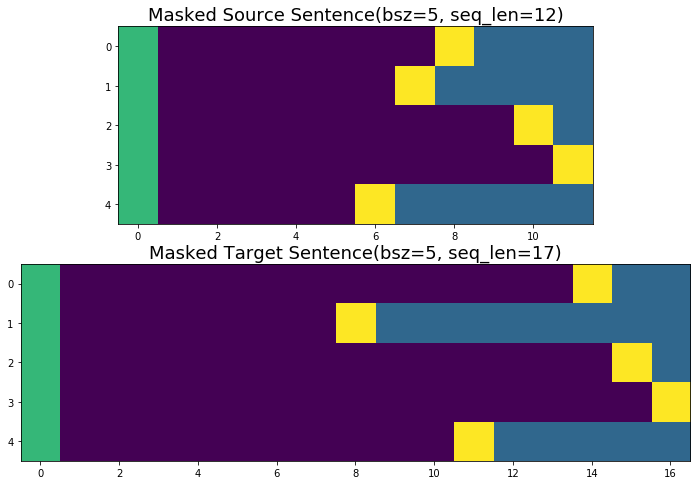

In [23]:
fig = plt.figure(figsize=(12, 8), facecolor='w')
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.imshow(x_.detach().numpy())
ax2.imshow(y_.detach().numpy())
ax1.set_title(f'Masked Source Sentence(bsz=5, seq_len={x_.size(1)})', fontsize=18)
ax2.set_title(f'Masked Target Sentence(bsz=5, seq_len={y_.size(1)})', fontsize=18)
plt.show()

Set HyperParameter of Transformer

In [24]:
INPUT_SIZE   = len(SRC_VOCAB_DICT)
OUTPUT_SIZE  = len(TRG_VOCAB_DICT)
HIDDEN_SIZE  = 256
N_SPLITS     = 8
N_ENC_BLOCKS = 6
N_DEC_BLOCKS = 6
DROPOUT_P    = 0.2

Start Transformer's Forward!

In [25]:
x

tensor([[    2, 10549,  3900, 45910,  3680, 45908,  2282,    16,     3,     1,
             1,     1],
        [    2,  2977,  5923,   956, 88842,    39,  2539,     3,     1,     1,
             1,     1],
        [    2,  1230,  1231,  1232,  1233,   323,  1234,  1235,  1236,   110,
             3,     1],
        [    2,  6726, 22523,  2457,   804, 61496,   105, 78511,  1664, 11442,
         71906,     3],
        [    2,  3085,   394,  2615,   133, 26667,     3,     1,     1,     1,
             1,     1]])

In [26]:
# make mask
mask = []
length = (x != 1).sum(dim=-1).tolist()
max_length = max(length)
for l in length:
    if max_length - l > 0:
        mask += [torch.cat([x.new_ones(1, l).zero_(),
                            x.new_ones(1, (max_length-l))
                           ], dim=-1)]
    else:
        mask += [x.new_ones(1, l).zero_()]
mask = torch.cat(mask, dim=0).bool()
mask # |mask| = (batch_size, n)

tensor([[False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False,  True,  True,  True,
          True,  True]])

In [27]:
x == SRC_VOCAB_DICT[PAD_TOKEN] # it is same to mask

tensor([[False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False,  True,  True,  True,
          True,  True]])

In [28]:
mask_enc = mask.unsqueeze(1).expand(mask.size(0), x.size(1), mask.size(-1))
mask_dec = mask.unsqueeze(1).expand(mask.size(0), y.size(1), mask.size(-1))

print(f"|mask_enc|={mask_enc.shape}=(batch_size, n, n)\n"
      f"|mask_dec|={mask_dec.shape}=(batch_size, m, n)")

|mask_enc|=torch.Size([5, 12, 12])=(batch_size, n, n)
|mask_dec|=torch.Size([5, 17, 12])=(batch_size, m, n)


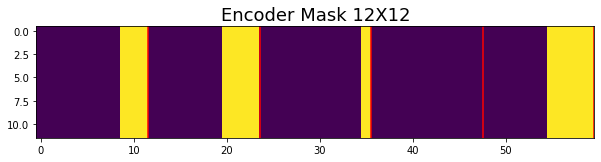

In [29]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(mask_enc.split(1, dim=0), dim=-1).squeeze().detach().numpy()
)
[plt.axvline(12*i-0.5, color='r') for i in range(1, 6)]
plt.title('Encoder Mask 12X12', fontsize=18)
plt.show()

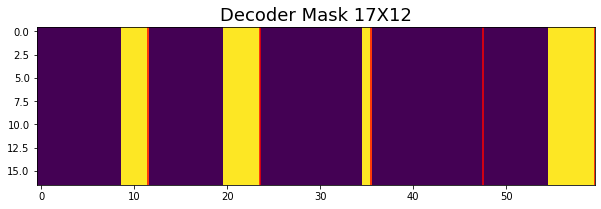

In [30]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(mask_dec.split(1, dim=0), dim=-1).squeeze().detach().numpy()
)
[plt.axvline(12*i-0.5, color='r') for i in range(1, 6)]
plt.title('Decoder Mask 17X12', fontsize=18)
plt.show()

$\text{EmbEncLayer}=\mathbb{N}_{[0,input\_size-1]} \rightarrow \mathbb{R}^{hidden\_size}$

In [31]:
# discrete token -> continuous token
# \mathbb{N}_{[0,input_size-1]} -> \mathbb{R}^{hidden_size}
emb_enc = nn.Embedding(INPUT_SIZE, HIDDEN_SIZE)
emb_enc.weight.size()

torch.Size([117303, 256])

In [32]:
embedded_x = emb_enc(x)
print(f"|emb_enc(x)|={embedded_x.shape}=(batch_size,n,hidden_size)")

|emb_enc(x)|=torch.Size([5, 12, 256])=(batch_size,n,hidden_size)


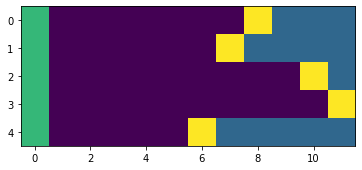

In [33]:
plt.figure(facecolor='w')
plt.imshow(x_.detach().numpy())

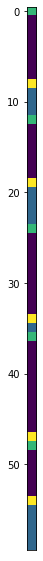

In [34]:
plt.figure(figsize=(10, 10), facecolor='w')
plt.imshow(x_.view(-1).unsqueeze(-1).detach().numpy())
plt.xticks([]); plt.show()

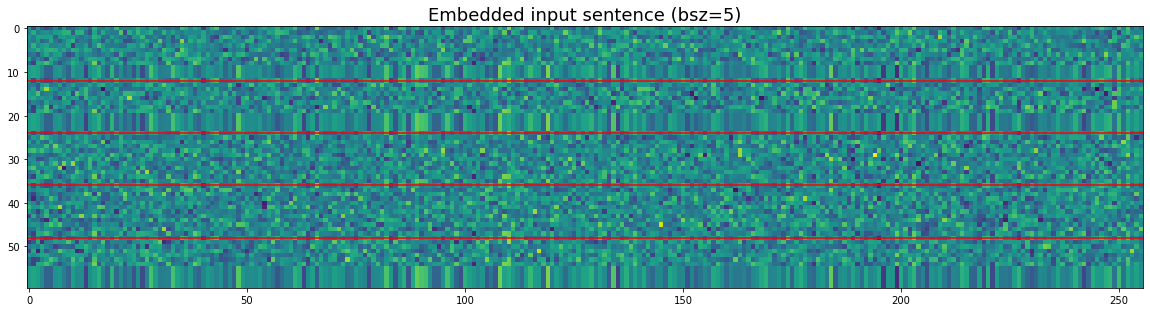

In [35]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    (embedded_x.view(-1, HIDDEN_SIZE)).detach().numpy()
)
for i in range(1, 5):
    plt.axhline(12*i, color='r')
plt.title('Embedded input sentence (bsz=5)', fontsize=18)
plt.show()

In [36]:
# _position_encoding
length, hidden_size = embedded_x.size()[1:]
print(f"length: {length} | hidden_size: {hidden_size}")
enc = embedded_x.new_zeros(embedded_x.shape[1:])
enc2 = embedded_x.new_zeros(embedded_x.shape[1:])
print(f"|enc|={enc.shape}=(n,hidden_size)")
init_pos = 0 # argument, default is 0
pos = init_pos + torch.arange(0, length).float().unsqueeze(-1)
dim = (10000. ** (torch.arange(0, hidden_size//2).div(hidden_size))).unsqueeze(0)
dim2 = (10000. ** (torch.arange(0, hidden_size).float().div(hidden_size))).unsqueeze(0)
dim2 = dim2[:, 0::2] # 짝수부분만 추출
enc[:, 0::2] = torch.sin(pos/dim)
enc[:, 1::2] = torch.cos(pos/dim)
enc2[:, 0::2] = torch.sin(pos/dim2)
enc2[:, 1::2] = torch.cos(pos/dim2)

length: 12 | hidden_size: 256
|enc|=torch.Size([12, 256])=(n,hidden_size)


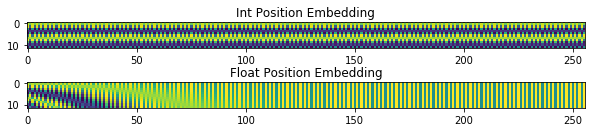

In [37]:
fig = plt.figure(figsize=(10, 2), facecolor='w')
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.imshow(enc.detach().numpy())
ax2.imshow(enc2.detach().numpy())
ax1.set_title('Int Position Embedding', fontsize=12)
ax2.set_title('Float Position Embedding', fontsize=12)
plt.show()

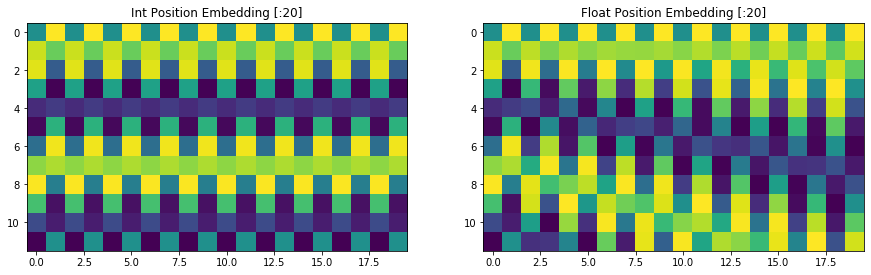

In [38]:
fig = plt.figure(figsize=(15, 20), facecolor='w')
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(enc[:, :20].detach().numpy())
ax2.imshow(enc2[:, :20].detach().numpy())
ax1.set_title('Int Position Embedding [:20]', fontsize=12)
ax2.set_title('Float Position Embedding [:20]', fontsize=12)
plt.show()

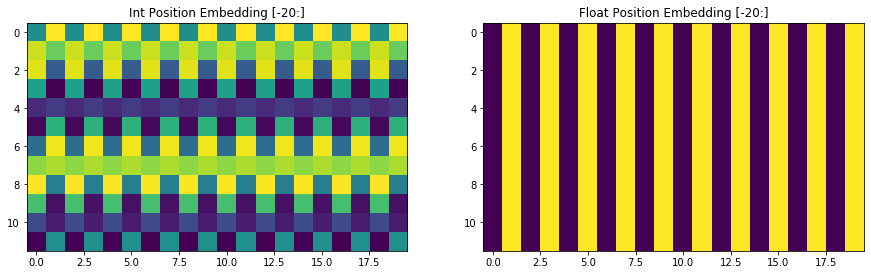

In [39]:
fig = plt.figure(figsize=(15, 20), facecolor='w')
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(enc[:, -20:].detach().numpy())
ax2.imshow(enc2[:, -20:].detach().numpy())
ax1.set_title('Int Position Embedding [-20:]', fontsize=12)
ax2.set_title('Float Position Embedding [-20:]', fontsize=12)
plt.show()

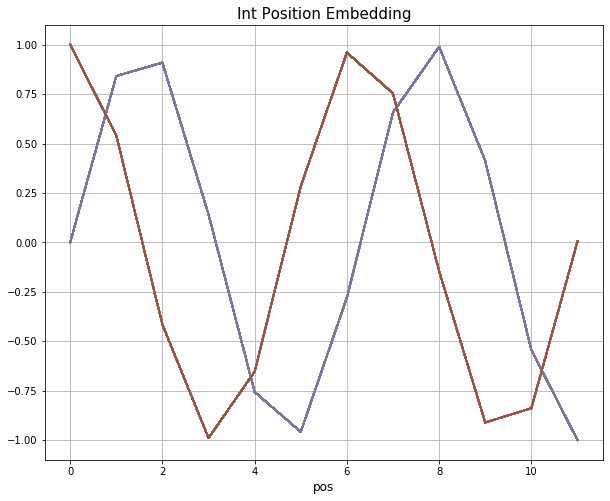

In [40]:
plt.figure(figsize=(10, 8), facecolor='w')
for i in range(hidden_size):
    plt.plot(enc[:, i].detach().numpy())
plt.title('Int Position Embedding', fontsize=15)
plt.xlabel('pos', fontsize=12)
plt.grid(True)
plt.show()

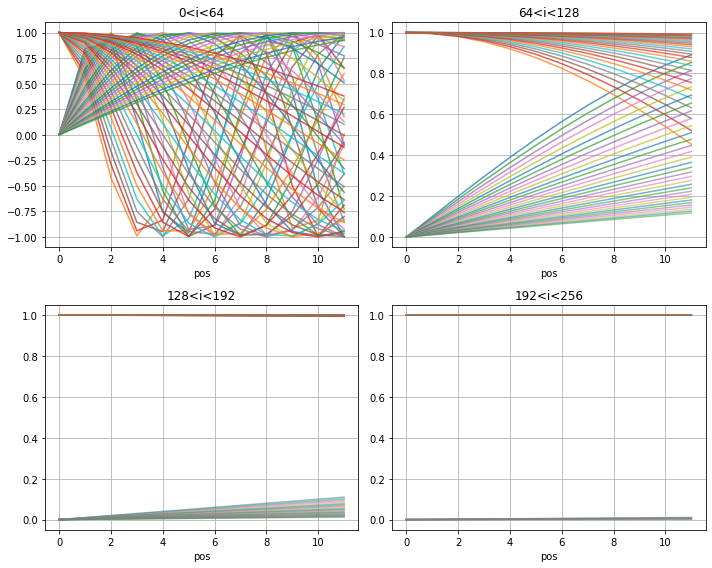

In [41]:
fig = plt.figure(figsize=(10, 8), facecolor='w')
mod = sys.modules[__name__]
for i in range(1, 5):
    setattr(mod, f'ax{i}', fig.add_subplot(2, 2, i))
    getattr(mod, f'ax{i}').set_title(f'{(i-1)*64}<i<{i*64}', fontsize=12)
    getattr(mod, f'ax{i}').set_xlabel('pos', fontsize=10)
    getattr(mod, f'ax{i}').grid(True)
for i in range(hidden_size):
    if i < 64:    ax = ax1
    elif i < 128: ax = ax2
    elif i < 192: ax = ax3
    else:         ax = ax4
    ax.plot(enc2[:, i].detach().numpy(), alpha=1-max(0.2, i/hidden_size))
# plt.subplots_adjust(bottom=-0.1)
plt.tight_layout()
plt.show()

In [42]:
embedded_x += enc

In [43]:
emb_dropout = nn.Dropout(DROPOUT_P)

In [44]:
z = emb_dropout(embedded_x)

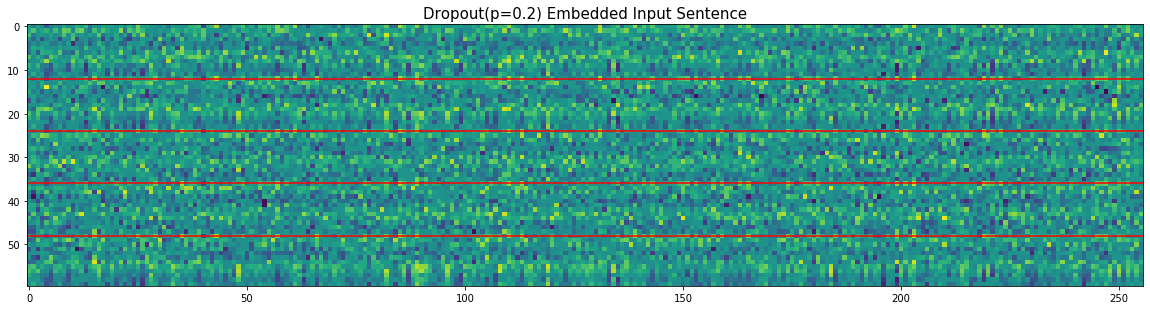

In [45]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    (z.view(-1, HIDDEN_SIZE)).detach().numpy()
)
for i in range(1, 5):
    plt.axhline(12*i, color='r')
plt.title(f'Dropout(p={DROPOUT_P}) Embedded Input Sentence', fontsize=15)
plt.show()

---
#### Dropout Layer를 잠시 살펴보자!

- `Dropout: A Simple Way to Prevent Neural Networks from Overfitting`에서 소개된 방법
- http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

![img](https://pozalabs.github.io/assets/images/dropout.PNG)

- neural network에서 unit들을 dropout시키는 것.
- 즉, 해당 unit을 network에서 일시적으로 제거
- 다른 unit과의 모든 connection이 사라짐
- 어떤 unit을 dropout할지는 random하게 정함
- dropout은 training data에 overfitting되는 문제를 어느정도 막아줌
- dropout된 unit들은 training되지 않는 것이니 training data에 값이 조정되지 않음

Standard neural network

$$z_i^{(l+1)}=w_i^{(l+1)}y^{(l)}+b_i^{(l+1)}$$
$$y_i^{(l+1)}=f\big({z_i^{(l+1)}}\big)$$


Dropout neural network

$$r_j^{(l)}\sim Bernoulli(p)$$
$$\tilde{y}^{(l)}=r^{(l)}*y^{(l)}$$
$$z_i^{(l+1)}=w_i^{(l+1)}\tilde{y}^{(l)}+b_i^{(l+1)}$$
$$y_i^{(l+1)}=f\big({z_i^{(l+1)}}\big)$$

In [46]:
ex = torch.randn((3,5))
ex

tensor([[-0.1874, -0.7823, -2.3526,  0.0459,  0.4824],
        [ 0.2657,  1.1274,  1.8159, -0.3767,  2.3072],
        [ 0.2197, -1.4757, -1.2042, -1.2720, -0.1731]])

In [47]:
z_ = nn.Dropout(0.3)(ex)
z_

tensor([[-0.2678, -1.1176, -3.3609,  0.0655,  0.0000],
        [ 0.3796,  1.6106,  0.0000, -0.0000,  0.0000],
        [ 0.3139, -2.1082, -1.7203, -1.8171, -0.2472]])

In [48]:
z_[z_ != 0] / ex[z_ != 0]

tensor([1.4286, 1.4286, 1.4286, 1.4286, 1.4286, 1.4286, 1.4286, 1.4286, 1.4286,
        1.4286, 1.4286])

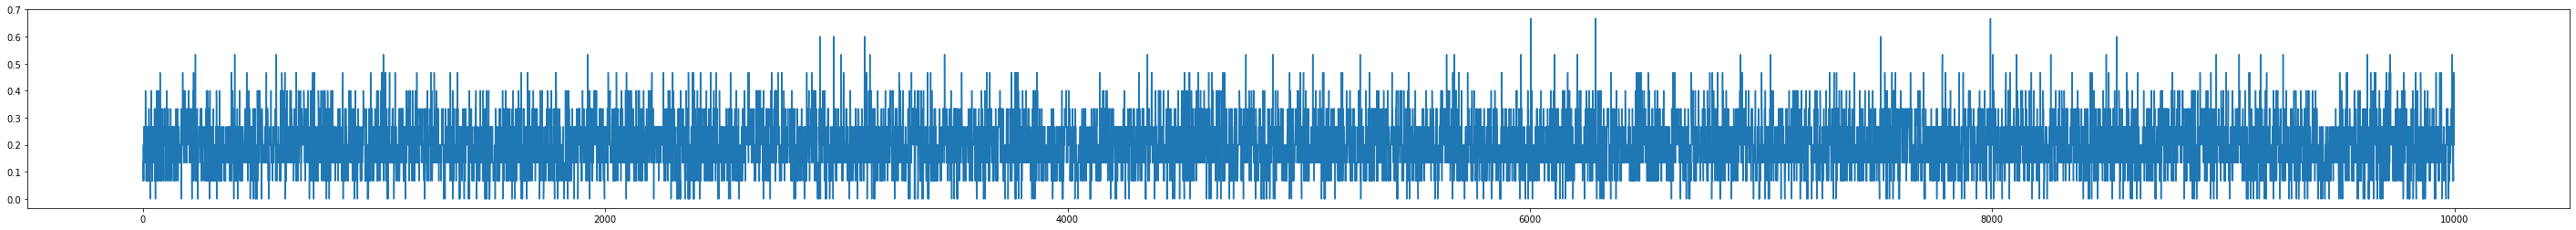

In [49]:
res = []
for i in range(10000):
    res.append(
        ((emb_dropout(torch.randn((3, 5))) == 0).sum().float() / 15).item()
    )
    
plt.figure(figsize=(50, 4), facecolor='w')
plt.plot(res)

In [50]:
np.mean(res)

0.2012333402186632

---

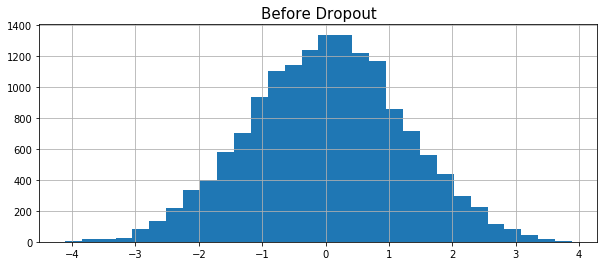

In [51]:
plt.figure(figsize=(10, 4), facecolor='w')
plt.hist(
    (embedded_x.view(-1, hidden_size)).flatten().detach().numpy(),
    bins=30
)
plt.grid(True)
plt.title('Before Dropout', fontsize=15)
plt.show()

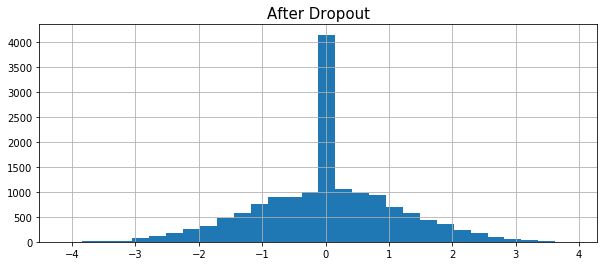

In [52]:
plt.figure(figsize=(10, 4), facecolor='w')
plt.hist(
    (z.view(-1, hidden_size) * (1 - DROPOUT_P)).flatten().detach().numpy(),
    bins=30
)
plt.grid(True)
plt.title('After Dropout', fontsize=15)
plt.show()

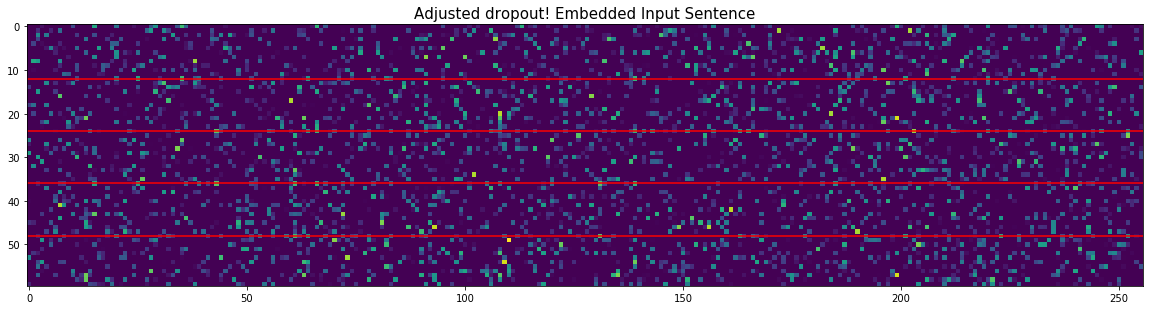

In [53]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    (torch.abs(embedded_x.view(-1, hidden_size) * (1 / (1 - DROPOUT_P)) - z.view(-1, hidden_size))).detach().numpy()
)
for i in range(1, 5):
    plt.axhline(12*i, color='r')
plt.title('Adjusted dropout! Embedded Input Sentence', fontsize=15)
plt.show()

In [54]:
1 - ((embedded_x - z * (1 - DROPOUT_P)) < 1e-10).sum().float() / (5 * 12 * 256)

tensor(0.1943)

In [55]:
print(z, z.shape)

tensor([[[ 4.3360e-01, -1.0143e+00,  4.1737e-01,  ..., -0.0000e+00,
           1.6893e-01, -0.0000e+00],
         [ 7.9851e-01,  2.0987e+00,  0.0000e+00,  ...,  6.5475e-01,
           0.0000e+00,  7.2034e-01],
         [ 1.7543e+00, -1.0039e+00,  0.0000e+00,  ...,  3.6957e-01,
           3.7569e+00,  6.1292e-01],
         ...,
         [ 1.2624e+00, -3.8690e-03,  1.4377e+00,  ..., -8.3362e-01,
           1.5153e+00, -8.5209e-01],
         [ 6.7232e-02,  0.0000e+00,  2.4251e-01,  ..., -7.4355e-01,
           0.0000e+00, -7.6202e-01],
         [-5.0273e-01,  1.1406e+00, -3.2745e-01,  ...,  3.1082e-01,
          -2.4983e-01,  0.0000e+00]],

        [[ 4.3360e-01, -1.0143e+00,  4.1737e-01,  ..., -1.1369e-01,
           1.6893e-01, -1.1663e-01],
         [ 3.4823e-01,  1.4174e-01, -8.5639e-01,  ...,  4.5033e-02,
           2.9658e-01,  6.5549e-01],
         [ 0.0000e+00,  2.3176e-01, -8.1956e-01,  ...,  9.6104e-01,
           1.7379e+00,  0.0000e+00],
         ...,
         [ 1.2624e+00, -0

Transformer는 Encoder와 Decoder 양쪽에 self-attention, point-wise 그리고 fc layer를 사용한 구조로 구성

![image](https://user-images.githubusercontent.com/37775784/77884189-8d0c9500-729f-11ea-8eef-87089ff83c10.png)

### 3.1 Encoder and Decoder Stacks

**Encoder**
- 6개의 Encoder Block으로 구성
- 각 Block은 두 sub-layer로 구성
    - Multi-Head Self-Attention Mechanism
    - Position-wise fully connected feed-forward network
- 위에 layer-normalization을 수행
- 각 sub-layer에 residual connection을 추가
- 즉, sub-layer의 output은 $\text{LayerNorm}(x+\text{Sublayer}(x))$
- Residual connection을 용이하게 수행하기 위해 모델의 모든 sub-layer와 embedding layers의 출력 차원은 $d_{model}=512$로 설정

**Decoder**
- 6개의 Decoder Block으로 구성
- Encoder Block의 sub-layer 사이에 multi-head attention layer를 삽입
- Encoder와 유사하게 각 sub-layer에 layer-normalization과 residual connection을 수행
- Decoder Block의 self-attention sub-layer의 mask부분을 수정
- output을 미리 알고있는 것은 언어도단
- 때문에 Query X Key 행렬이 $\mathbb{R}^{m\times n}$의 원소라면 $m<n$인 부분을 masking

### 3.2 Attention

<img src="https://user-images.githubusercontent.com/37775784/78321933-46bd7b80-75a8-11ea-83bf-bbec3b0a8759.PNG">

$$\text{Attention}(Q,K,V)=\text{softmax}(\cfrac{QK^T}{\sqrt{d_k}})V$$

$$\begin{align}
\text{MultiHead(Q,K,V)}&=\text{Concat}(head_1,\dots,head_h)W^O\\
\text{where }head_i&=\text{Attention}(QW_i^{Q},KW_i^{K},VW_i^{V})\\
W_i^{Q}&\in\mathbb{R}^{d_{model}\times d_k},\;W_i^{K}\in\mathbb{R}^{d_{model}\times d_k},\;W_i^{V}\in\mathbb{R}^{d_{model}\times d_v}\\
d_k&=d_v=d_{model}/h=64,\;h=8\\
\end{align}$$

#### Additive Attention vs Multiplicative Attention

- 가장 흔하게 쓰는 `attention function`은 `additive model`과 `dot-product(multiplicative)` attention이 존재
- 전자는 Neural Machine Translation by Jointly Learning to Align and Translate에서 소개된 방식
- 후자가 본 논문의 방식
- `Additive attention`은 단일 hidden layer를 가진 feed-forward network를 사용하여 `compativility function`을 계산
- `Dot-product Attention`이 더 빠르고 메모리 효율적!
- `Highly optimized matrix multiplicaition code`를 사용하여 구현했기 때문!

#### Why Scaling?
- 작은 $d_k$를 사용한 경우 위의 두 mechanism의 성능이 유사했지만
- 큰 $d_k$에 대해선 `additive attention`이 scaling factor를 적용하지 않은 `dot-product attention`보다 우월
- 왜 그랬을까? 추정하기로 $d_k$의 큰 값에 대해 내적(dot-product)의 크기가 커져 softmax 함수가 gradient가 매우 작은 영역으로 push!
    - 무슨 말인가? 왜 내적값이 커지는가?
    - $q$와 $k$의 요소가 서로 독립인 평균 0, 분산 1을 가지는 random variable이라고 가정
    - 이 때 $q$와 $k$의 내적 $q \cdot k = \sum_{i=1}^{d_k}{q_i k_i}$는 평균 0 그리고 분산 $d_k$를 가짐
    - 때문에 $d_k$가 커질수록(차원이 커질수록) variation이 늘어나고 이에 내적 값이 커질 가능성이 커지며
    - 이 값에 exponential을 씌워 softmax를 만들면 극단적인 값이 생성됨(학습이 안됨!)
- 이에 대한 대책으로 내적 값에 $\frac{1}{\sqrt{d_k}}$를 곱해 scaling

#### Applications of Attention in Transformer
아래 세 가지 방법으로 Attention Mechanism을 사용
1. `Encoder-Decoder attention` layer에서 query는 이전 decoder layer에서, memory key와 value는 encoder output에서 온다. 이는 decoder의 모든 position이 입력 시퀀스의 모든 position에 집중할 수 있게한다. 이는 [31, 2, 9]와 같은 전형적인 seq2seq model의 encoder-decoder attention mechanism을 흉내낸다.
    - [Google's neural machine translation system: Bridging the gap between human and machine translation](https://arxiv.org/abs/1609.08144)
    - [Neural machine translation by jointly learning to align and translate](https://arxiv.org/abs/1409.0473)
    - [Generating sequences with recurrent neural networks](https://arxiv.org/abs/1308.0850)

2. Encoder는 selt-attention layer를 포함한다. attention layer에서 모든 key, value, query는 같은 공간, encoder의 이전 layer의 output에서 나온다. encoder의 각 position은 encoder의 이전 layer의 모든 position에 집중한다.

3. 유사하게, decoder의 self-attention layer들은 decoder의 각 position이 해당 position까지, 혹은 이를 포함하는 모든 position에 대해 집중할 수 있게한다. 우리는 `auto-regressive` 성질을 보존하기 위해 decoder의 `leftward information` flow를 방지해야 한다. 이에 우리는 `scaled dot-product attention` 내부를 구현함에 있어 softmax의 input에 $-\infty$로 masking하여 `illegal`하게 연결되도록 한다.

### 3.3 Position-wise Feed-Forward Networks

attention의 sub-layers이외에 encoder와 decoder의 각 layer들은 각 position에 대해 분리적, 동일하게 적용되는 fully connected feed-forward network를 또 하나 가지고 있다. 두 linear transformation 사이에 ReLU activation을 낀 ffn은 아래와 같다.
$$\text{FFN}(x)=\max(0,xW_1+b_1)W_2+b_2$$
linear transformation은 서로 다른 위치에서 위와 같이 동일하게 실시하지만 layer에서 layer로 갈 때는 다른 paremeter를 사용한다. 이를 다르게 설명하자면 kernel size를 1로 둔 두 convolution을 생각하면 될 것 같다. input와 output 차원은 $d_{model}=512$이며 inner-layer는 $d_{ff}=2048$ 차원을 가지고 있다.

### 3.4 Embeddings and Softmax
다른 sequence transduction 모델과 유사하게 우리는 input, output token을 $d_{model}$ 차원의 벡터로 바꾸는 embedding을 학습할 때 모델을 사용한다. 또한 다음 token의 등장 확률을 예측하기 위해 decoder의 output을 변환할 linear transformation과 softmax 함수를 사용한다. 우리의 모델에서 두 embedding layer와 pre-softmax transformation 사이의 두 weight matrix를 [30]과 유사하게 공유한다. embedding layer에서 우리는 두 weight에 $\sqrt{d_{model}}$을 곱해줬다.
- [Rethinking the inception architecture for computer vision](https://arxiv.org/abs/1512.00567)

## Regularization

#### Resiaul Dropout
- 각 sub-layer의 출력에 dropout[33]을 적용하고 이를 sub-layer 입력에 추가하여 정규화한다
- encoder와 decoder stack 둘의 positional encodings과 embedding의 합에도 dropout을 적용했다. base model에서 $P_{drop}=0.1$을 적용했다

#### Label Smoothing
- label smoothing을 $\epsilon_{ls}=0.1$로 수행했다. 이는 모델의 perplexity를 증가시키며 모델이 모호함을 느끼게 만들지만 정확도와 BLEU score를 향상시켰다.
- [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/pdf/1512.00567.pdf)에서 소개
- training동안 실제 정답인 label의 logit은 다른 logit보다 훨씬 큰 값을 가짐
- 이렇게 해서 model이 주어진 input $x$에 대한 label $y$를 맞추는 것
- 그러나 이렇게 되면 문제가 발생.
    - overfitting이 될 수도 있고 가장 큰 logit을 가지는 것과 나머지 사이의 차이를 점점 크게 만듦
    - 결국 model이 다른 data에 적응하는 능력을 감소시킴
- model이 덜 confident하게 만들기 위해, label distribution $q{(k|x)}=\delta_{k,y}$를 (k가 y일 경우 1, 나머지는 0) 다음과 같이 대체 가능

$$q^\prime(k|x)=(1-\epsilon)\delta_{k,y}+\epsilon u(k)$$

- 각각 label에 대한 분포 $u(k)$, smoothing parameter $\epsilon$.
- 위와 같다면, k=y인 경우 model은 $p(y|x)=1$이 아니라 $p(y|x)=(1-\epsilon)$이 됨
- 100%의 확신이 아닌 그보다 덜한 확신을 하게 되는 것

## (+) Prerequisite

#### Layer Normalization
[Layer Normalization](https://arxiv.org/abs/1607.06450)에서 제시된 방법

$$\begin{array}c
\mu^l=\cfrac{1}{H}\sum_{i=1}^{H}a_i^l\\\\
\sigma^l=\sqrt{\cfrac{1}{H}\sum_{i=1}^{H}{(a_i^l-\mu^l)}^2}
\end{array}$$

- 같은 layer에 있는 모든 hidden unit은 동일한 $\mu$와 $\sigma$를 공유
- 그리고 현재 input $x^t$, 이전의 hidden state $h^{t-1}$, $a_t=W_{hh}h^{t-1}+W_{xh}x^t$, parameter $g,b$가 있을 떄 다음과 같이 `normalization` 수행

$$h^t=f[\cfrac{g}{\sigma^t}\odot(a^t-\mu^t)+b]$$

- 이렇게 하면 gradient가 exploding하거나 vanishing하는 문제를 완화시키고 gradient 값이 안정적인 값을 가짐으로 더 빨리 학습시킬 수 있다.

출처: https://pozalabs.github.io/transformer/

#### Residual Connection
[Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027)에서 제시된 방법

[Residual Networks Behave Like Ensembles of Relatively Shallow Networks](https://arxiv.org/abs/1605.06431)이 논문도 읽어라.

- 아래 수식이 Residual Connection을 나타냄.

$$\begin{array}c
y_l=h(x_l)+F(x_l,W_l)\\\\
x_{l+1}=f(y_l),\quad where\;h(x_l)=x_l\\
\end{array}$$
- identity mapping

- In general,
$$\begin{array}c
x_2=x_1+F(x_1,W_1)\\\\
x_3=x_2+F(x_2,W_2)=x_1+F(x_1,W_1)+F(x_2,W_2)\\\\
\vdots\\\\
x_L=x_l+\sum_{i=1}^{L-1}F(x_i,W_i)
\end{array}$$

- Differentiate, (use chain-rule)
$$\cfrac{\sigma\epsilon}{\sigma x_l}=
\cfrac{\sigma\epsilon}{\sigma x_L}\cdot\cfrac{\sigma x_L}{\sigma x_l}=
\cfrac{\sigma\epsilon}{\sigma x_L}
(1+\cfrac{\sigma}{\sigma x_l}\sum_{i=1}^{L-1}F(x_i,W_i))$$

- $\cfrac{\sigma\epsilon}{\sigma x_L}$은 상위 layer의 gradient값이 변하지 않고 하위 layer에 전달되는 것을 보여줌.
- 즉, layer를 거칠수록 gradient가 사라지는 vanishing gradient 문제를 완하시킴
- 또한 forward path나 backward path를 간단하게 표현할 수 있게 됨
- Highway Gateway는 Residual Connection의 상위 호환(ResNet의!)

출처:
- https://pozalabs.github.io/transformer/
- https://github.com/YBIGTA/DeepNLP-Study/wiki/Residual-Networks-Behave-Like-Ensembles-of-Relatively-Shallow-Networks

In [56]:
# Encoder Block 1

## MultiHead-Attention
Q_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_1   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = z
mask = mask_enc

QWs = Q_linear_1(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_1(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_1(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_1(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_1 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_1 = nn.Dropout(DROPOUT_P)
### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_1 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_1 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_1 = nn.Dropout(DROPOUT_P)

z = attn_norm_1(z + attn_dropout_1(c))
z = fc_norm_1(z + fc_dropout_1(fc_1(z)))

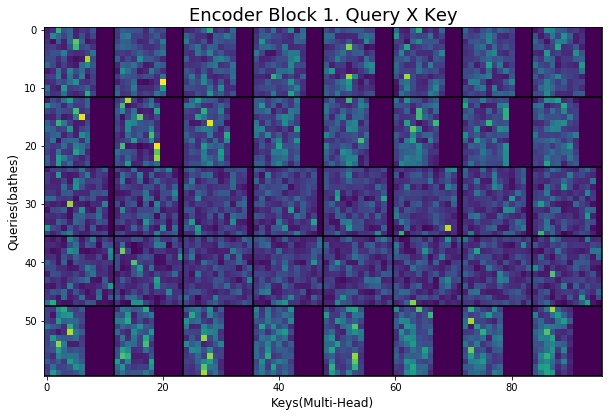

In [57]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='k')
plt.title('Encoder Block 1. Query X Key', fontsize=18)
plt.xlabel('Keys(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

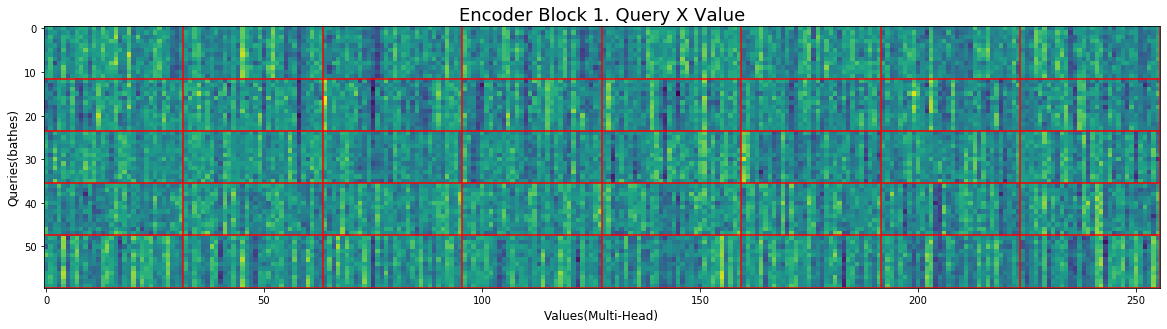

In [58]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')
plt.title('Encoder Block 1. Query X Value', fontsize=18)
plt.xlabel('Values(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

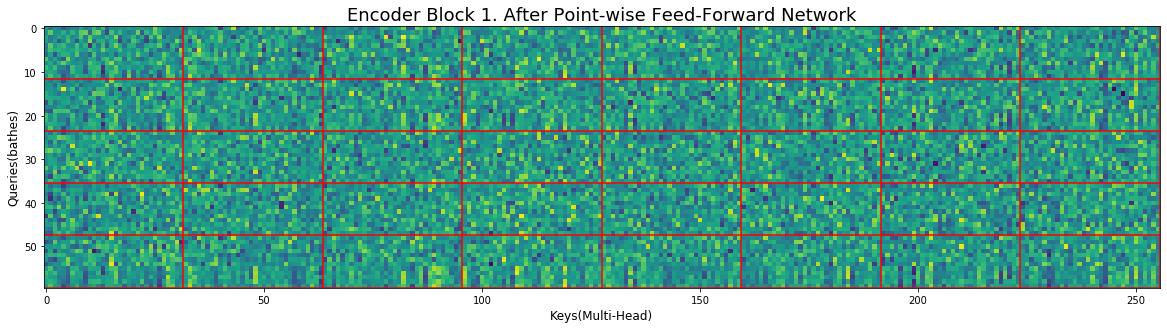

In [59]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    z.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')
plt.title('Encoder Block 1. After Point-wise Feed-Forward Network', fontsize=18)
plt.xlabel('Keys(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

In [60]:
# Encoder Block 2

## MultiHead-Attention
Q_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_2   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = z
mask = mask

QWs = Q_linear_2(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_2(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_2(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

# mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_2(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_2 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_2 = nn.Dropout(DROPOUT_P)
### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_2 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_2 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_2 = nn.Dropout(DROPOUT_P)

z = attn_norm_2(z + attn_dropout_2(c))
z = fc_norm_2(z + fc_dropout_2(fc_2(z)))

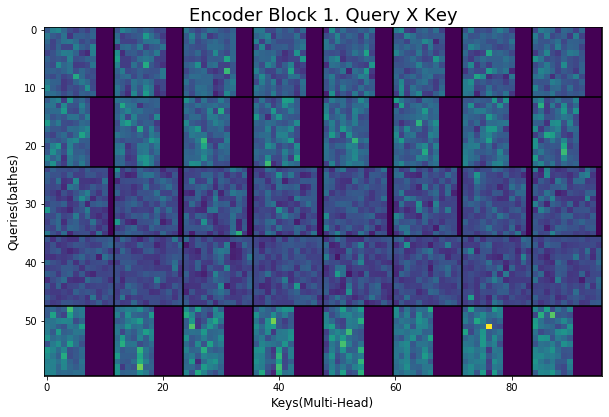

In [61]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='k')
plt.title('Encoder Block 1. Query X Key', fontsize=18)
plt.xlabel('Keys(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

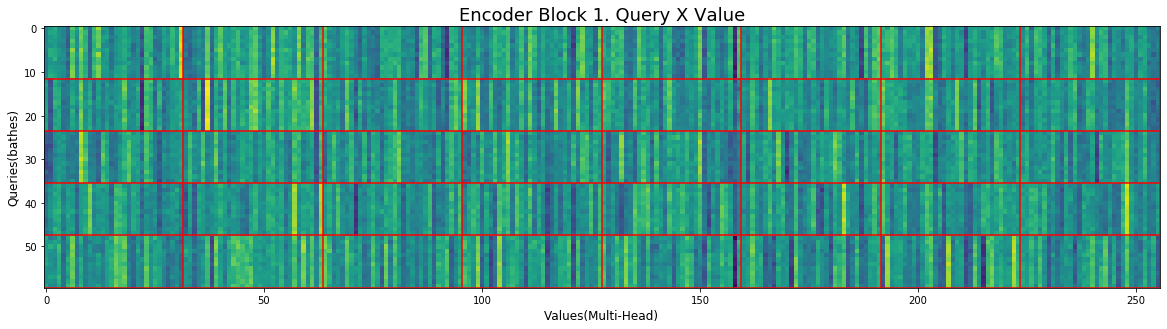

In [62]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')
plt.title('Encoder Block 1. Query X Value', fontsize=18)
plt.xlabel('Values(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

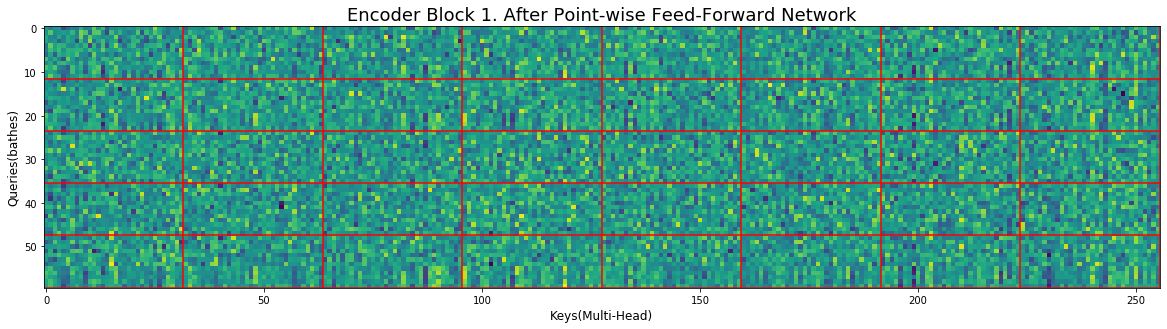

In [63]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    z.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')
plt.title('Encoder Block 1. After Point-wise Feed-Forward Network', fontsize=18)
plt.xlabel('Keys(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

In [64]:
# Encoder Block 3

## MultiHead-Attention
Q_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_3   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = z
mask = mask

QWs = Q_linear_3(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_3(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_3(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

# mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_3(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_3 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_3 = nn.Dropout(DROPOUT_P)
### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_3 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_3 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_3 = nn.Dropout(DROPOUT_P)

z = attn_norm_3(z + attn_dropout_3(c))
z = fc_norm_3(z + fc_dropout_3(fc_3(z)))

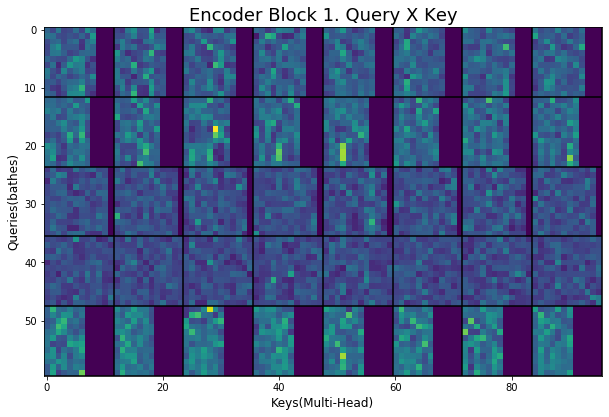

In [65]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='k')
plt.title('Encoder Block 1. Query X Key', fontsize=18)
plt.xlabel('Keys(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

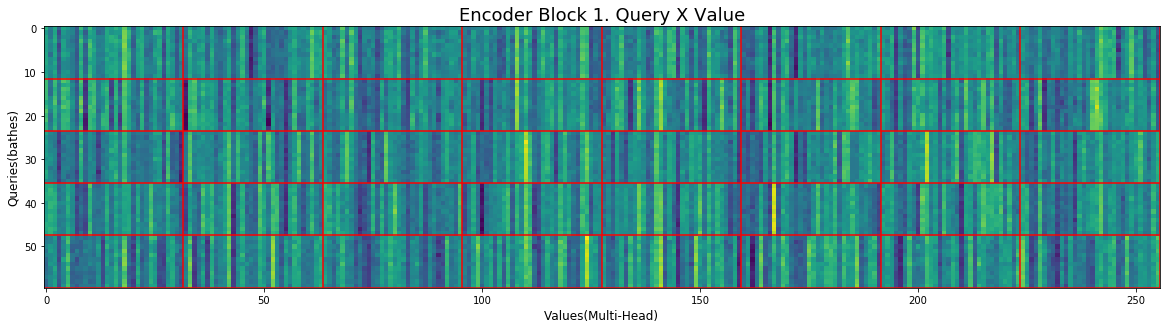

In [66]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')
plt.title('Encoder Block 1. Query X Value', fontsize=18)
plt.xlabel('Values(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

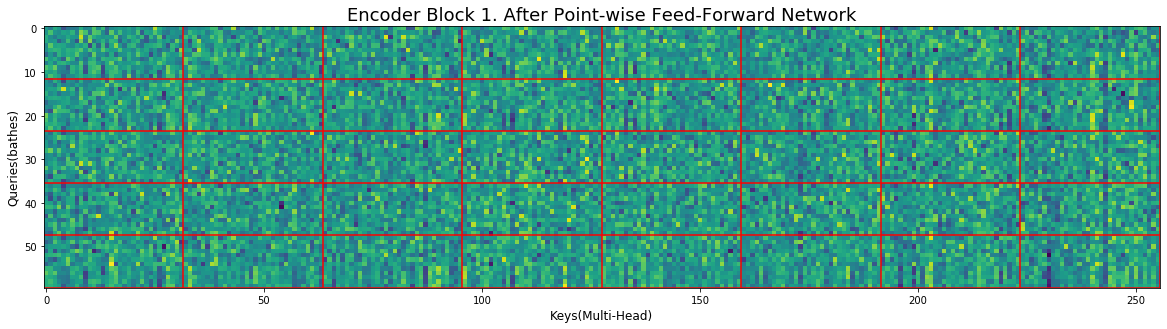

In [67]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    z.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')
plt.title('Encoder Block 1. After Point-wise Feed-Forward Network', fontsize=18)
plt.xlabel('Keys(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

In [68]:
# Encoder Block 4

## MultiHead-Attention
Q_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_4   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = z
mask = mask

QWs = Q_linear_4(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_4(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_4(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

# mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_4(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_4 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_4 = nn.Dropout(DROPOUT_P)
### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_4 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_4 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_4 = nn.Dropout(DROPOUT_P)

z = attn_norm_4(z + attn_dropout_4(c))
z = fc_norm_4(z + fc_dropout_4(fc_4(z)))

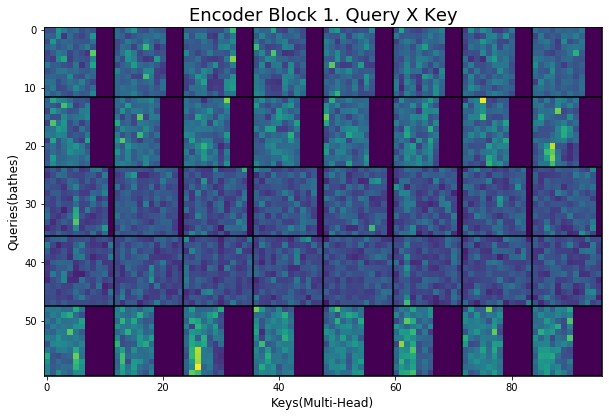

In [69]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='k')
plt.title('Encoder Block 1. Query X Key', fontsize=18)
plt.xlabel('Keys(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

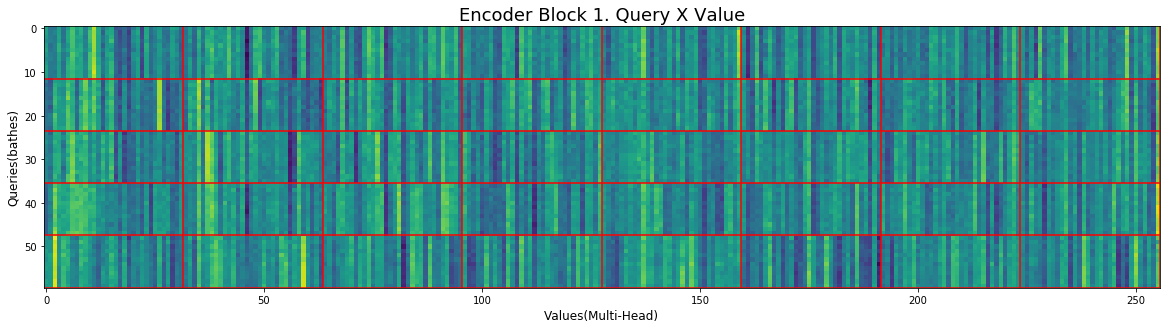

In [70]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')
plt.title('Encoder Block 1. Query X Value', fontsize=18)
plt.xlabel('Values(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

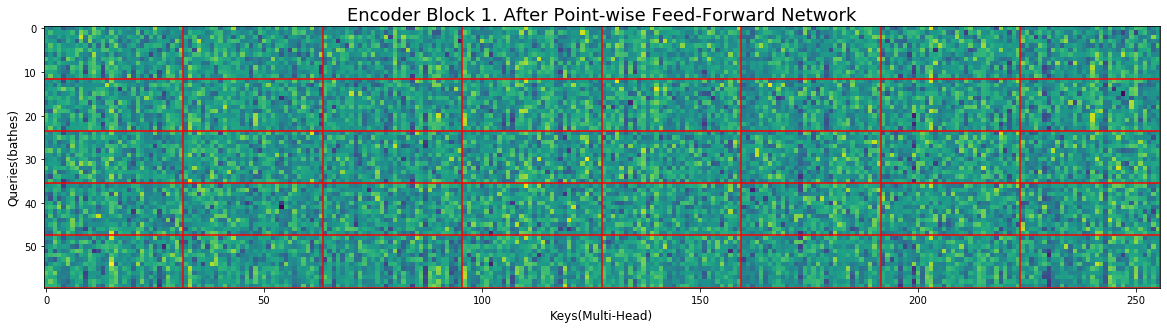

In [71]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    z.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')
plt.title('Encoder Block 1. After Point-wise Feed-Forward Network', fontsize=18)
plt.xlabel('Keys(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

In [72]:
# Encoder Block 5

## MultiHead-Attention
Q_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_5   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = z
mask = mask

QWs = Q_linear_5(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_5(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_5(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

# mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_5(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_5 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_5 = nn.Dropout(DROPOUT_P)
### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_5 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_5 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_5 = nn.Dropout(DROPOUT_P)

z = attn_norm_5(z + attn_dropout_5(c))
z = fc_norm_5(z + fc_dropout_5(fc_5(z)))

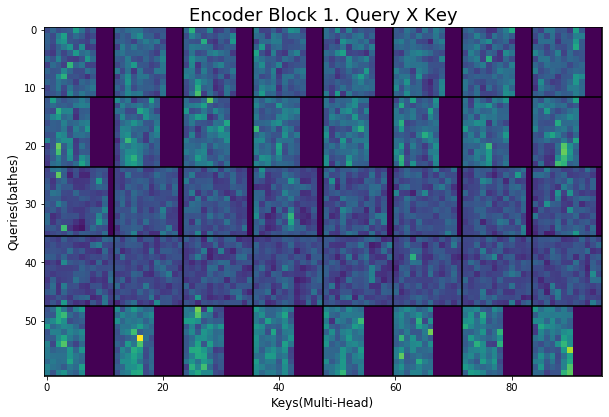

In [73]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='k')
plt.title('Encoder Block 1. Query X Key', fontsize=18)
plt.xlabel('Keys(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

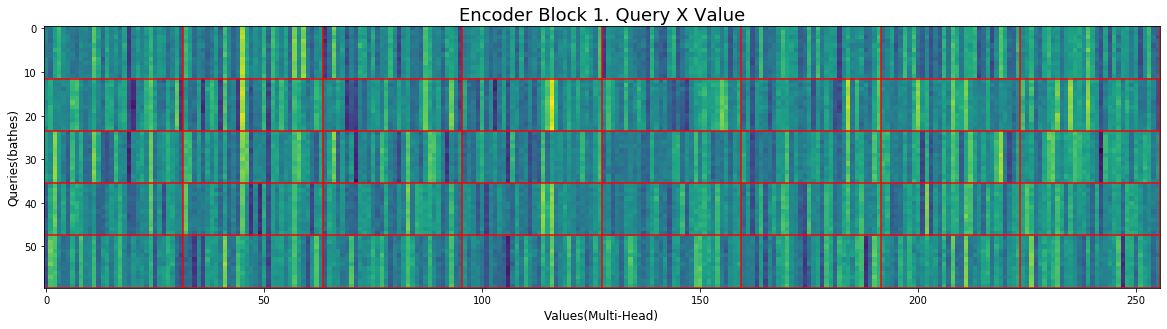

In [74]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')
plt.title('Encoder Block 1. Query X Value', fontsize=18)
plt.xlabel('Values(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

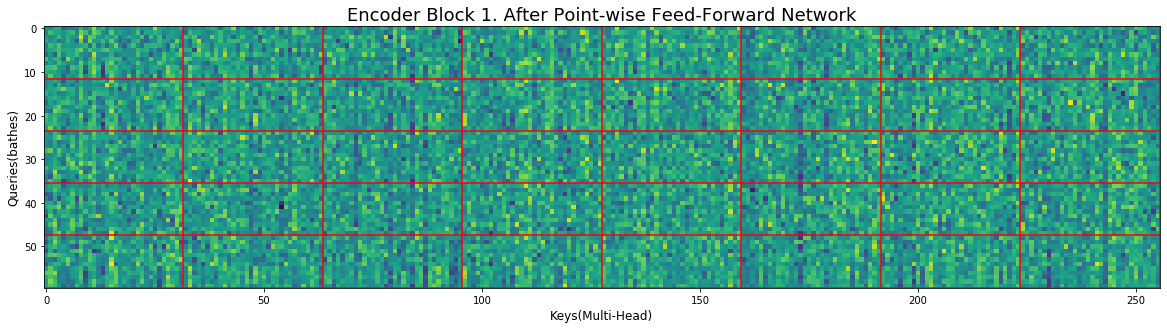

In [75]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    z.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')
plt.title('Encoder Block 1. After Point-wise Feed-Forward Network', fontsize=18)
plt.xlabel('Keys(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

In [76]:
# Encoder Block 6

## MultiHead-Attention
Q_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_6   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = z
mask = mask

QWs = Q_linear_6(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_6(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_6(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

# mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_6(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_6 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_6 = nn.Dropout(DROPOUT_P)
### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_6 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_6 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_6 = nn.Dropout(DROPOUT_P)

z = attn_norm_6(z + attn_dropout_6(c))
z = fc_norm_6(z + fc_dropout_6(fc_6(z)))

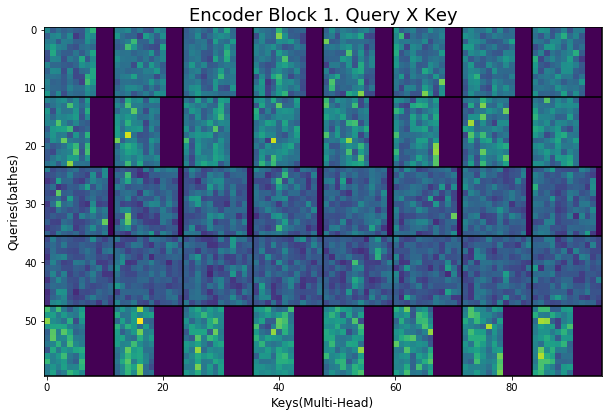

In [77]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='k')
plt.title('Encoder Block 1. Query X Key', fontsize=18)
plt.xlabel('Keys(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

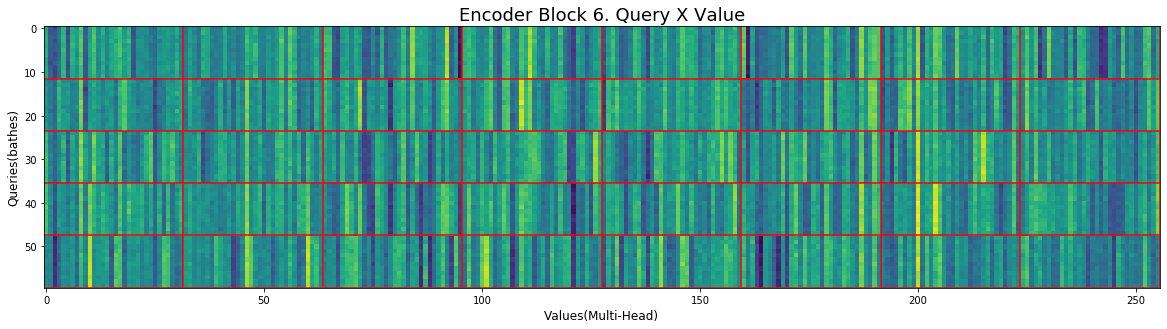

In [78]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')
plt.title('Encoder Block 6. Query X Value', fontsize=18)
plt.xlabel('Values(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

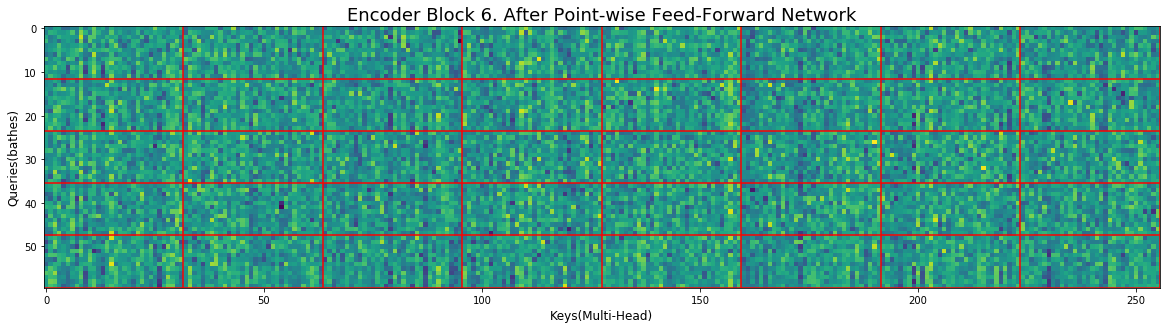

In [79]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    z.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')
plt.title('Encoder Block 6. After Point-wise Feed-Forward Network', fontsize=18)
plt.xlabel('Keys(Multi-Head)', fontsize=12); plt.ylabel('Queries(bathes)', fontsize=12)
plt.show()

In [80]:
mask_dec.shape

torch.Size([5, 17, 12])

$\text{EmbDecLayer}=\mathbb{N}_{[0,output\_size-1]} \rightarrow \mathbb{R}^{hidden\_size}$

In [81]:
# discrete token -> continuous token
# \mathbb{N}_{[0,input_size-1]} -> \mathbb{R}^{hidden_size}
emb_dec = nn.Embedding(OUTPUT_SIZE, HIDDEN_SIZE)
emb_dec.weight.size()

torch.Size([34308, 256])

In [82]:
embedded_y = emb_dec(y)
print(f"|emb_dec(y)|={embedded_y.shape}=(batch_size,m,hidden_size)")

|emb_dec(y)|=torch.Size([5, 17, 256])=(batch_size,m,hidden_size)


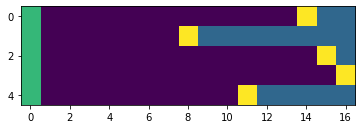

In [83]:
plt.imshow(y_.detach().numpy())

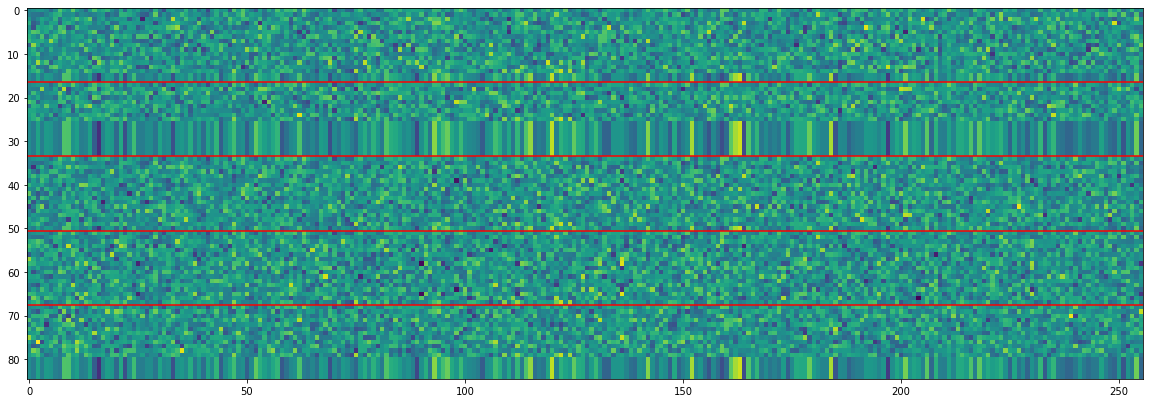

In [84]:
plt.figure(figsize=(20, 16))
plt.imshow(
    (embedded_y.view(-1, HIDDEN_SIZE)).detach().numpy()
)
for i in range(1, 5):
    plt.axhline(17*i-0.5, color='r')

In [85]:
# _position_encoding
length, hidden_size = embedded_y.size()[1:]
print(f"length: {length} | hidden_size: {hidden_size}")
dec = embedded_y.new_zeros(embedded_y.shape[1:])
print(f"|enc|={enc.shape}=(n,hidden_size)")
init_pos = 0 # argument, default is 0
pos = init_pos + torch.arange(0, length).float().unsqueeze(-1)
dim = (10000. ** (torch.arange(0, hidden_size//2).div(hidden_size))).unsqueeze(0)
dec[:, 0::2] = torch.sin(pos/dim)
dec[:, 1::2] = torch.cos(pos/dim)

length: 17 | hidden_size: 256
|enc|=torch.Size([12, 256])=(n,hidden_size)


In [86]:
embedded_y += dec

In [87]:
h = emb_dropout(embedded_y)

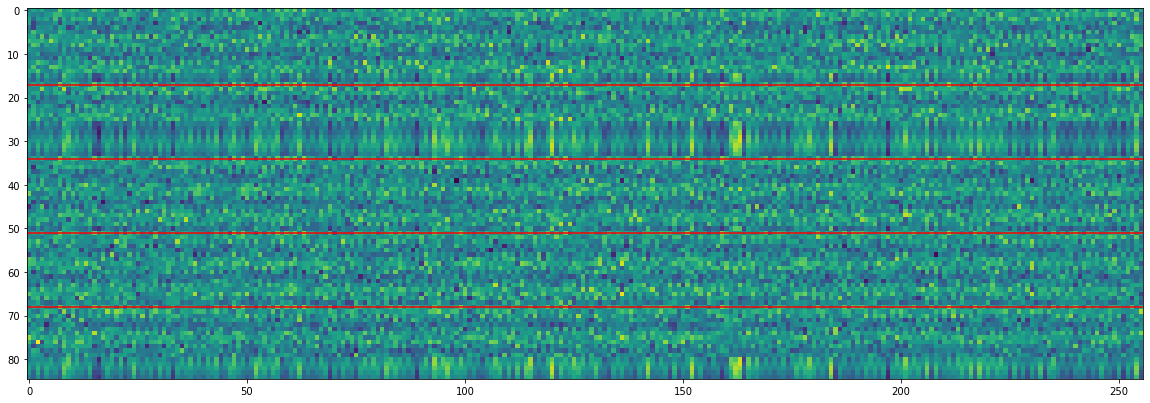

In [88]:
plt.figure(figsize=(20, 16))
plt.imshow(
    (embedded_y.view(-1, HIDDEN_SIZE)).detach().numpy()
)
for i in range(1, 5):
    plt.axhline(17*i, color='r')

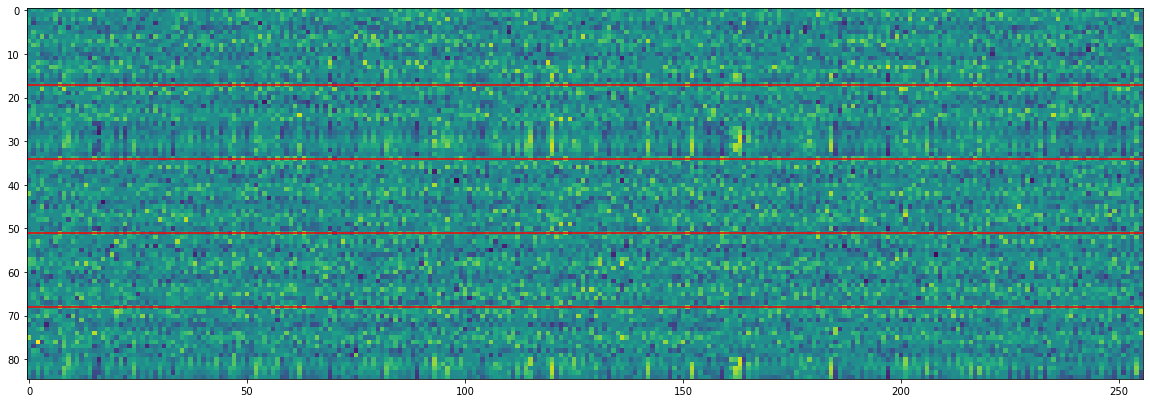

In [89]:
plt.figure(figsize=(20, 16))
plt.imshow(
    (h.view(-1, HIDDEN_SIZE)).detach().numpy()
)
for i in range(1, 5):
    plt.axhline(17*i, color='r')

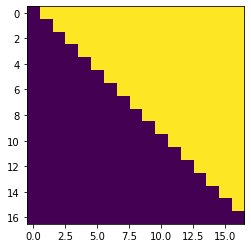

In [90]:
plt.imshow(torch.triu(h.new_ones((17, 17)), diagonal=1).bool().detach().numpy())

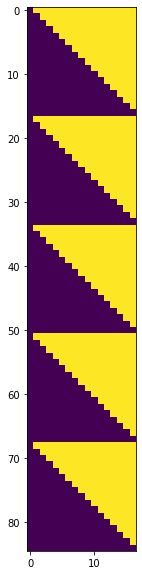

In [91]:
plt.figure(figsize=(5, 10))
t = torch.triu(h.new_ones((17, 17)), diagonal=1).bool()
plt.imshow(
    t.unsqueeze(0).expand(5, 17, 17).contiguous().view(-1, 17).detach().numpy()
)

In [92]:
key_and_value = z

In [93]:
h = emb_dropout(embedded_y)

In [94]:
# Decoder Block 1

## prev는 search를 위한 것
batch_size, m = h.size()[:-1]
fwd_mask = torch.triu(h.new_ones((m, m)), diagonal=1).bool()
fwd_mask = fwd_mask.unsqueeze(0).expand(batch_size, *fwd_mask.size())

## masked MultiHead-Attention
masked_Q_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_K_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_V_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_linear_1   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = h
mask = fwd_mask

QWs = masked_Q_linear_1(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = masked_K_linear_1(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = masked_V_linear_1(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
masked_w = torch.bmm(QWs, KWs.transpose(1, 2))
masked_w.masked_fill_(mask, -float('inf'))
masked_w = softmax(masked_w / (dk ** .5))
masked_c = torch.bmm(masked_w, VWs)

masked_c = masked_c.split(Q.size(0), dim=0)
masked_c = masked_linear_1(torch.cat(masked_c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
masked_attn_norm_1 = nn.LayerNorm(HIDDEN_SIZE)
masked_attn_dropout_1 = nn.Dropout(DROPOUT_P)

h = masked_attn_norm_1(h + masked_attn_dropout_1(masked_c))

## MultiHead-Attention
Q_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_1   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = h
V = K = key_and_value
mask = mask_dec

QWs = Q_linear_1(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_1(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_1(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_1(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_1 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_1 = nn.Dropout(DROPOUT_P)

h = attn_norm_1(h + attn_dropout_1(c))

### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_1 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_1 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_1 = nn.Dropout(DROPOUT_P)

h = fc_norm_1(h + fc_dropout_1(fc_1(h)))

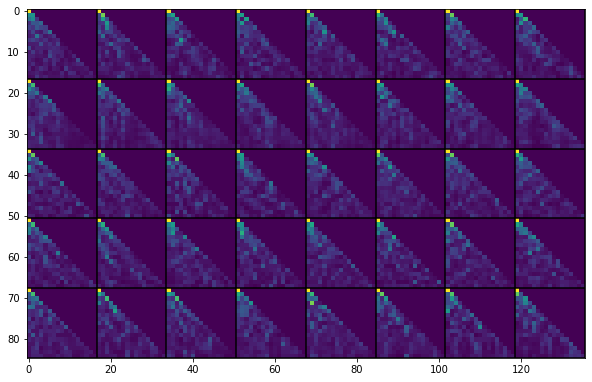

In [95]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(masked_w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(17*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

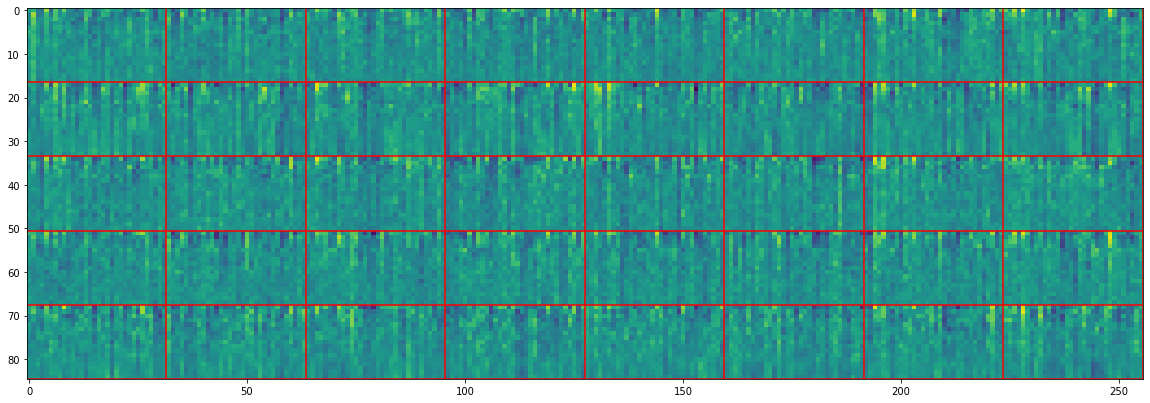

In [96]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    masked_c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

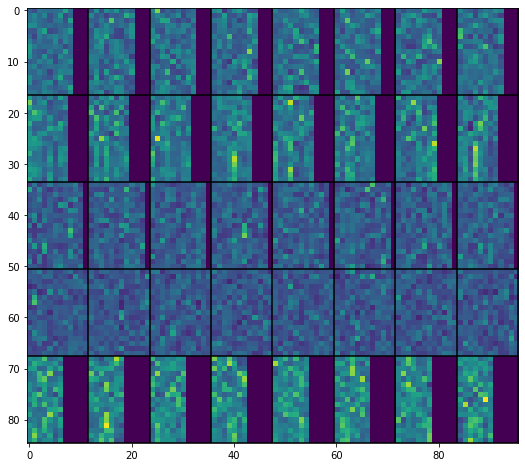

In [97]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

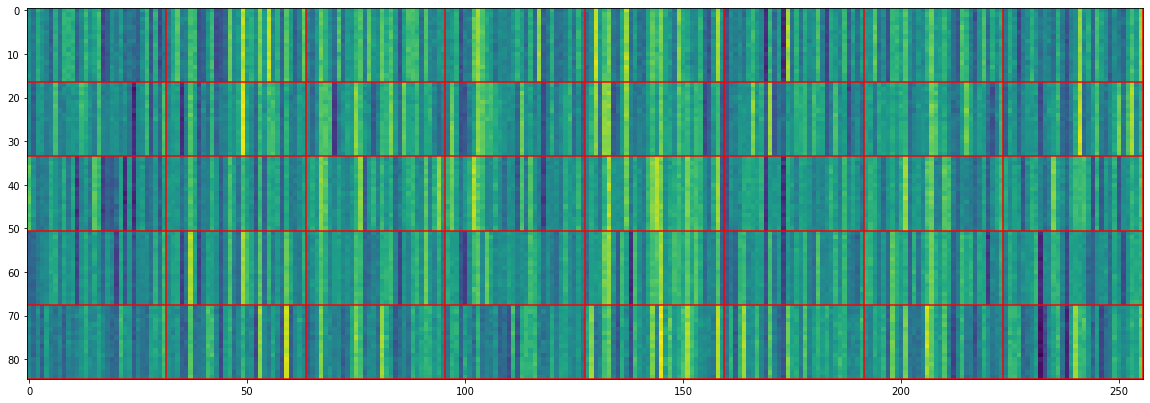

In [98]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

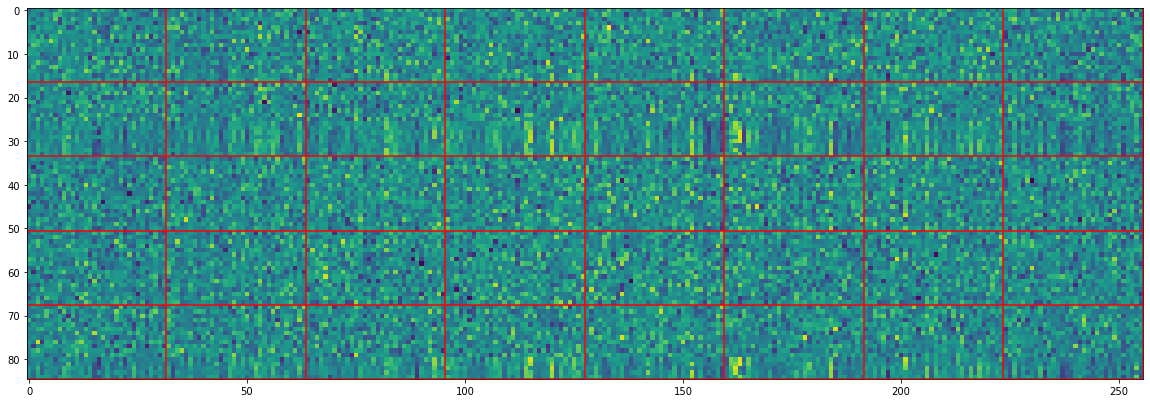

In [99]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    h.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

In [100]:
# Decoder Block 2

## prev는 search를 위한 것
batch_size, m = h.size()[:-1]
fwd_mask = torch.triu(h.new_ones((m, m)), diagonal=1).bool()
fwd_mask = fwd_mask.unsqueeze(0).expand(batch_size, *fwd_mask.size())

## masked MultiHead-Attention
masked_Q_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_K_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_V_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_linear_2   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = h
mask = fwd_mask

QWs = masked_Q_linear_2(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = masked_K_linear_2(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = masked_V_linear_2(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
masked_w = torch.bmm(QWs, KWs.transpose(1, 2))
masked_w.masked_fill_(mask, -float('inf'))
masked_w = softmax(masked_w / (dk ** .5))
masked_c = torch.bmm(masked_w, VWs)

masked_c = masked_c.split(Q.size(0), dim=0)
masked_c = masked_linear_2(torch.cat(masked_c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
masked_attn_norm_2 = nn.LayerNorm(HIDDEN_SIZE)
masked_attn_dropout_2 = nn.Dropout(DROPOUT_P)

h = masked_attn_norm_2(h + masked_attn_dropout_2(masked_c))

## MultiHead-Attention
Q_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_2   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = h
V = K = key_and_value
mask = mask_dec

QWs = Q_linear_2(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_2(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_2(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_2(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_2 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_2 = nn.Dropout(DROPOUT_P)

h = attn_norm_2(h + attn_dropout_2(c))

### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_2 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_2 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_2 = nn.Dropout(DROPOUT_P)

h = fc_norm_2(h + fc_dropout_2(fc_2(h)))

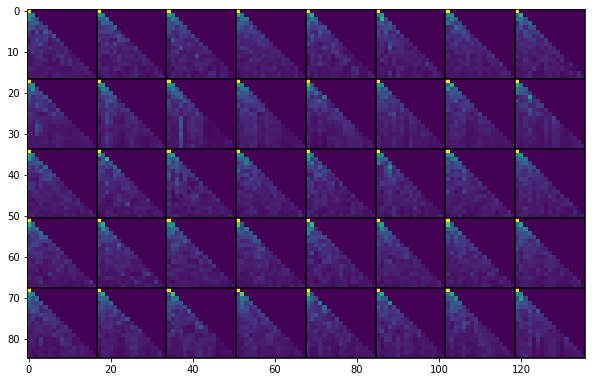

In [101]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(masked_w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(17*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

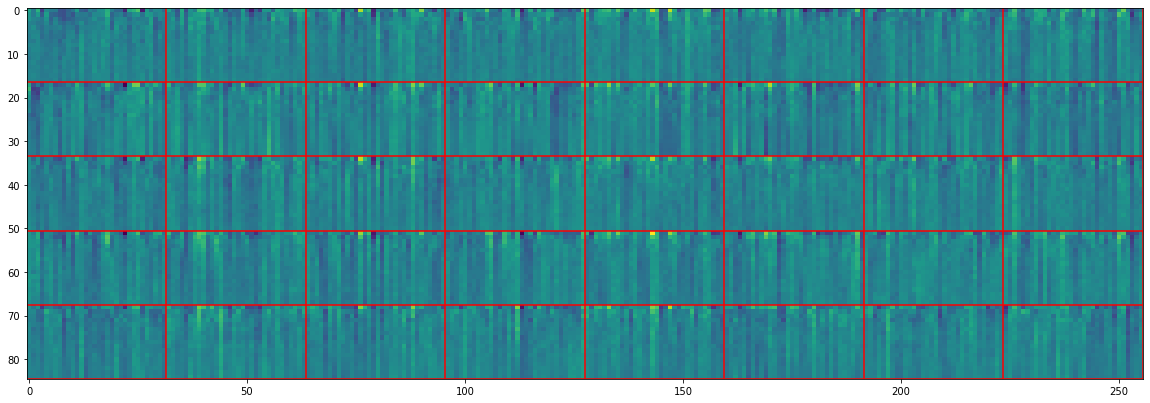

In [102]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    masked_c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

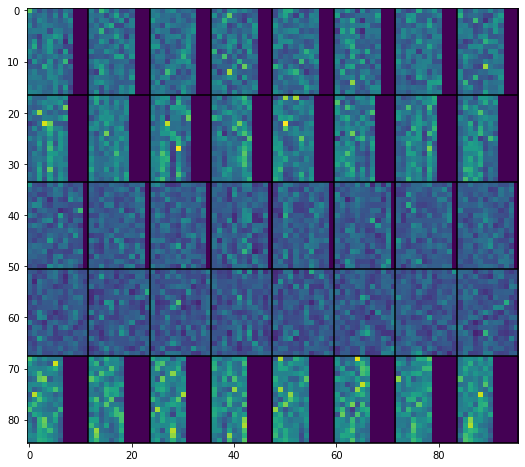

In [103]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

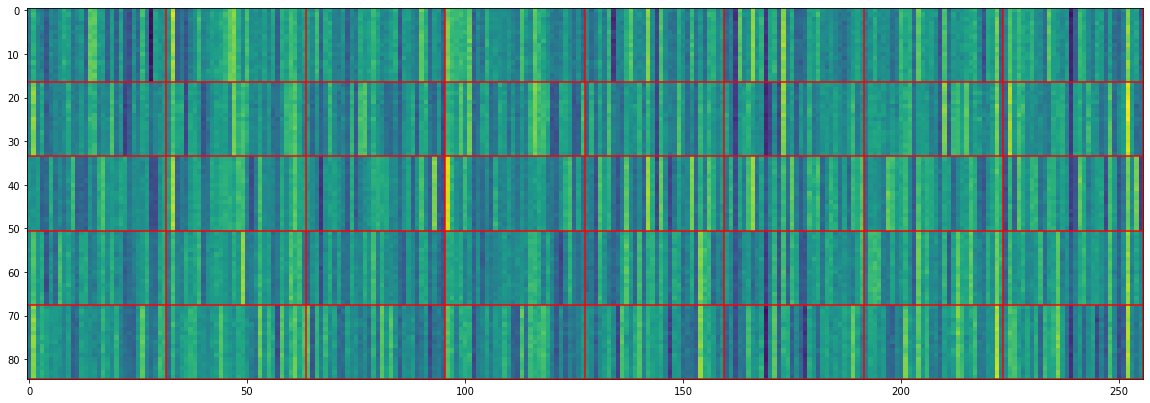

In [104]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

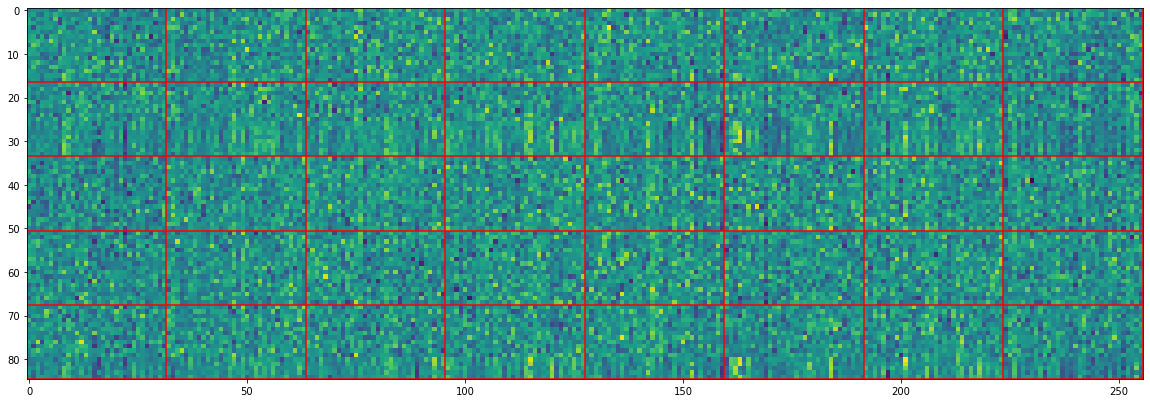

In [105]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    h.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

In [106]:
# Decoder Block 3

## prev는 search를 위한 것
batch_size, m = h.size()[:-1]
fwd_mask = torch.triu(h.new_ones((m, m)), diagonal=1).bool()
fwd_mask = fwd_mask.unsqueeze(0).expand(batch_size, *fwd_mask.size())

## masked MultiHead-Attention
masked_Q_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_K_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_V_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_linear_3   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = h
mask = fwd_mask

QWs = masked_Q_linear_3(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = masked_K_linear_3(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = masked_V_linear_3(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
masked_w = torch.bmm(QWs, KWs.transpose(1, 2))
masked_w.masked_fill_(mask, -float('inf'))
masked_w = softmax(masked_w / (dk ** .5))
masked_c = torch.bmm(masked_w, VWs)

masked_c = masked_c.split(Q.size(0), dim=0)
masked_c = masked_linear_3(torch.cat(masked_c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
masked_attn_norm_3 = nn.LayerNorm(HIDDEN_SIZE)
masked_attn_dropout_3 = nn.Dropout(DROPOUT_P)

h = masked_attn_norm_3(h + masked_attn_dropout_3(masked_c))

## MultiHead-Attention
Q_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_3   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = h
V = K = key_and_value
mask = mask_dec

QWs = Q_linear_3(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_3(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_3(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_3(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_3 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_3 = nn.Dropout(DROPOUT_P)

h = attn_norm_3(h + attn_dropout_3(c))

### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_3 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_3 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_3 = nn.Dropout(DROPOUT_P)

h = fc_norm_3(h + fc_dropout_3(fc_3(h)))

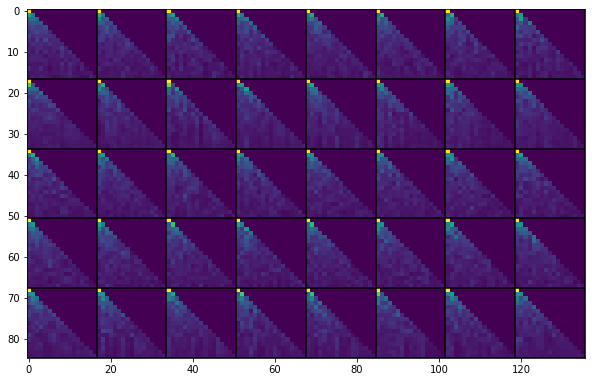

In [107]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(masked_w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(17*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

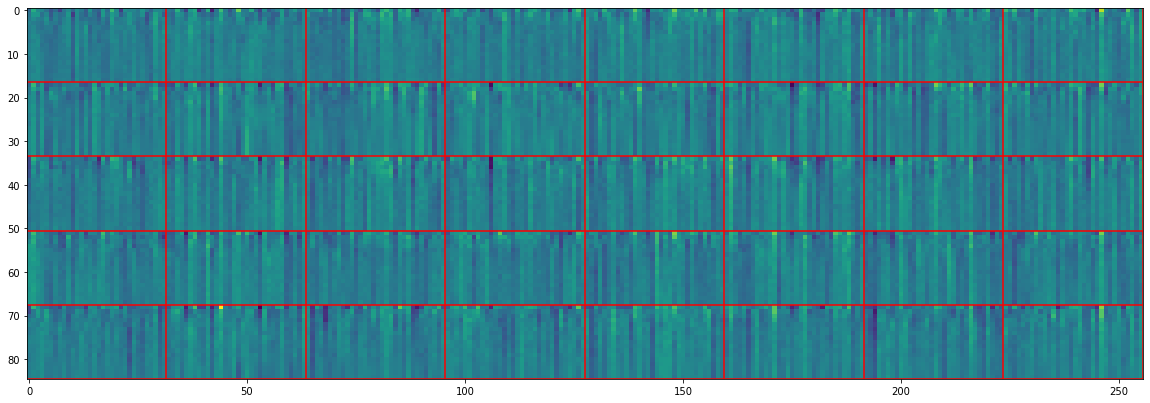

In [108]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    masked_c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

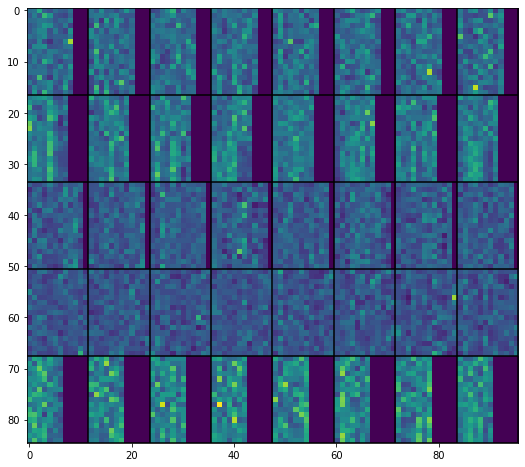

In [109]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

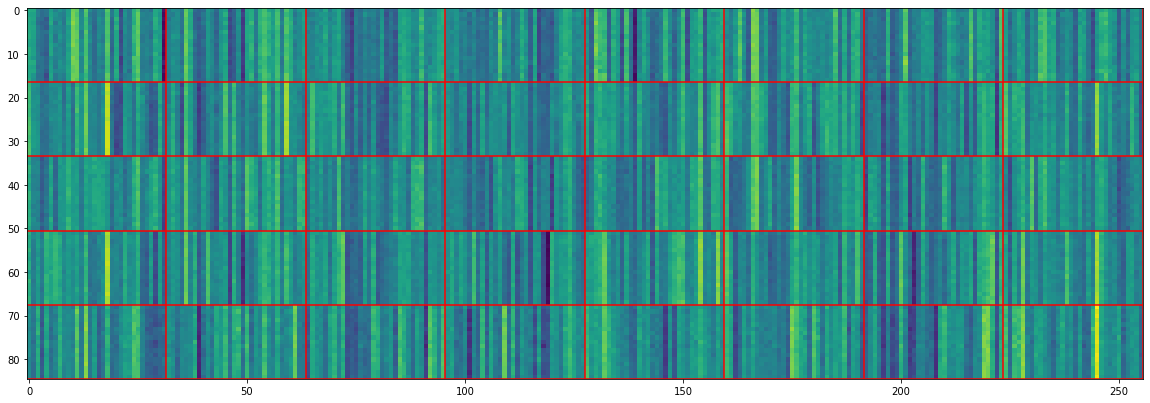

In [110]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

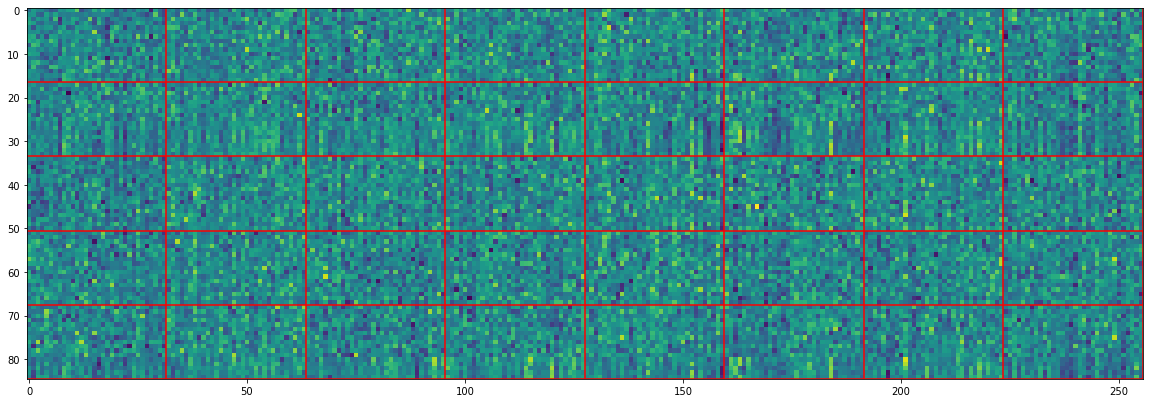

In [111]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    h.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

In [112]:
# Decoder Block 4

## prev는 search를 위한 것
batch_size, m = h.size()[:-1]
fwd_mask = torch.triu(h.new_ones((m, m)), diagonal=1).bool()
fwd_mask = fwd_mask.unsqueeze(0).expand(batch_size, *fwd_mask.size())

## masked MultiHead-Attention
masked_Q_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_K_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_V_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_linear_4   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = h
mask = fwd_mask

QWs = masked_Q_linear_4(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = masked_K_linear_4(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = masked_V_linear_4(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
masked_w = torch.bmm(QWs, KWs.transpose(1, 2))
masked_w.masked_fill_(mask, -float('inf'))
masked_w = softmax(masked_w / (dk ** .5))
masked_c = torch.bmm(masked_w, VWs)

masked_c = masked_c.split(Q.size(0), dim=0)
masked_c = masked_linear_4(torch.cat(masked_c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
masked_attn_norm_4 = nn.LayerNorm(HIDDEN_SIZE)
masked_attn_dropout_4 = nn.Dropout(DROPOUT_P)

h = masked_attn_norm_4(h + masked_attn_dropout_4(masked_c))

## MultiHead-Attention
Q_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_4   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = h
V = K = key_and_value
mask = mask_dec

QWs = Q_linear_4(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_4(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_4(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_4(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_4 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_4 = nn.Dropout(DROPOUT_P)

h = attn_norm_4(h + attn_dropout_4(c))

### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_4 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_4 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_4 = nn.Dropout(DROPOUT_P)

h = fc_norm_4(h + fc_dropout_4(fc_4(h)))

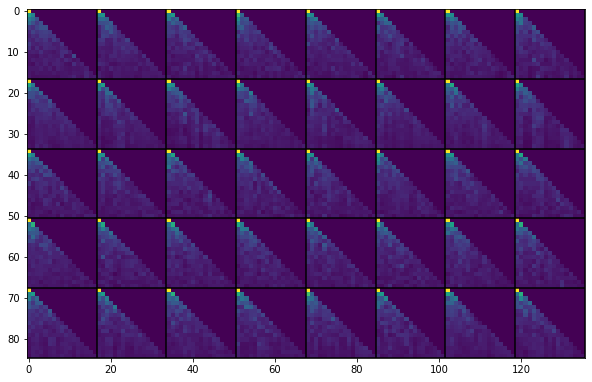

In [113]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(masked_w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(17*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

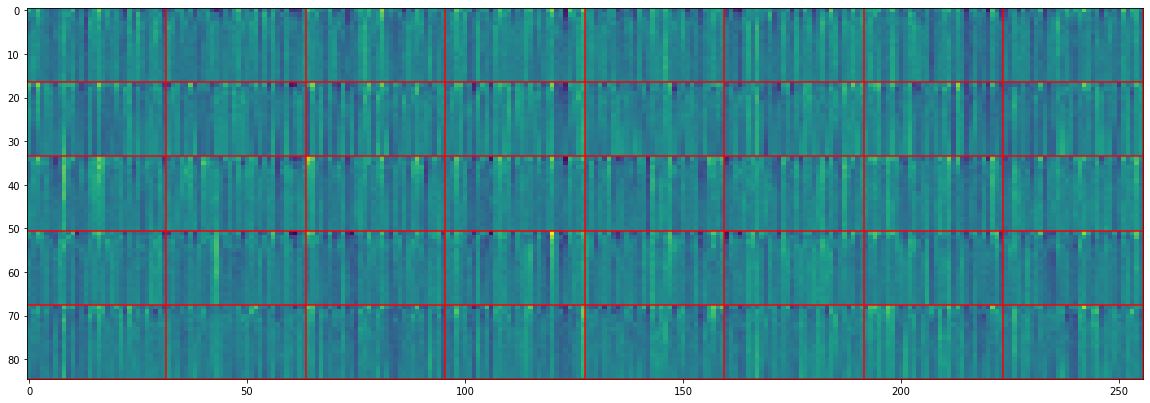

In [114]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    masked_c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

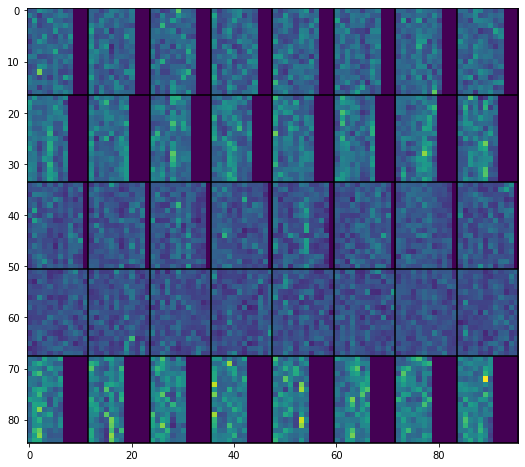

In [115]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

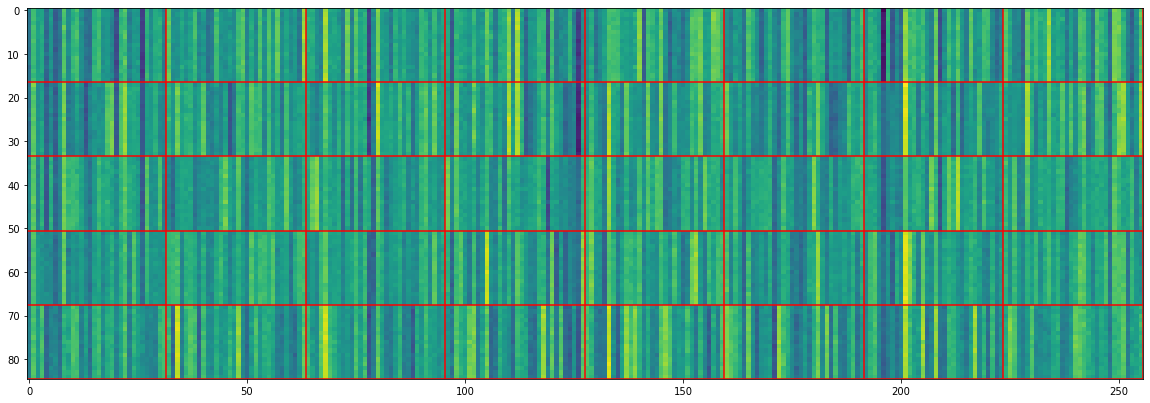

In [116]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

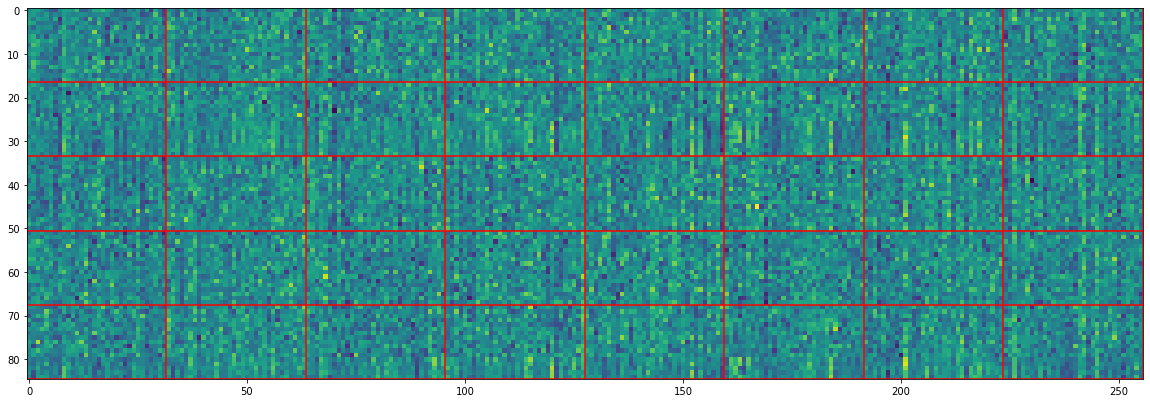

In [117]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    h.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

In [118]:
# Decoder Block 5

## prev는 search를 위한 것
batch_size, m = h.size()[:-1]
fwd_mask = torch.triu(h.new_ones((m, m)), diagonal=1).bool()
fwd_mask = fwd_mask.unsqueeze(0).expand(batch_size, *fwd_mask.size())

## masked MultiHead-Attention
masked_Q_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_K_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_V_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_linear_5   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = h
mask = fwd_mask

QWs = masked_Q_linear_5(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = masked_K_linear_5(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = masked_V_linear_5(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
masked_w = torch.bmm(QWs, KWs.transpose(1, 2))
masked_w.masked_fill_(mask, -float('inf'))
masked_w = softmax(masked_w / (dk ** .5))
masked_c = torch.bmm(masked_w, VWs)

masked_c = masked_c.split(Q.size(0), dim=0)
masked_c = masked_linear_5(torch.cat(masked_c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
masked_attn_norm_5 = nn.LayerNorm(HIDDEN_SIZE)
masked_attn_dropout_5 = nn.Dropout(DROPOUT_P)

h = masked_attn_norm_5(h + masked_attn_dropout_5(masked_c))

## MultiHead-Attention
Q_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_5   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = h
V = K = key_and_value
mask = mask_dec

QWs = Q_linear_5(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_5(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_5(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_5(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_5 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_5= nn.Dropout(DROPOUT_P)

h = attn_norm_5(h + attn_dropout_5(c))

### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_5 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_5 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_5 = nn.Dropout(DROPOUT_P)

h = fc_norm_5(h + fc_dropout_5(fc_5(h)))

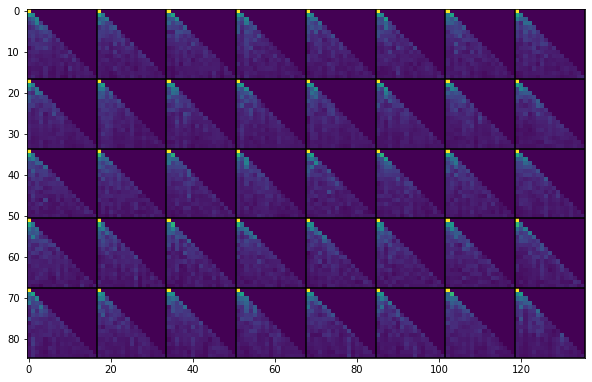

In [119]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(masked_w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(17*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

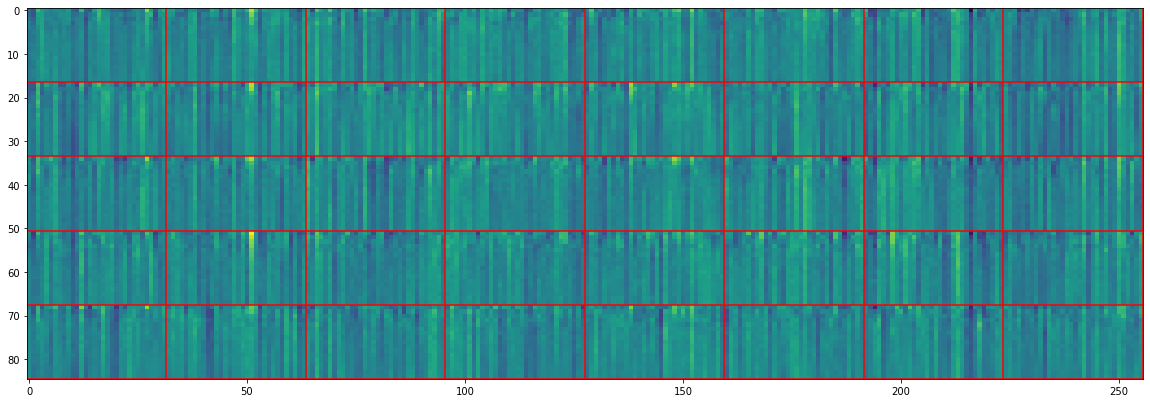

In [120]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    masked_c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

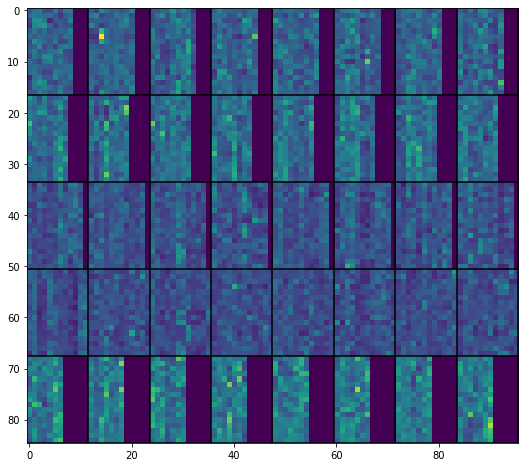

In [121]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

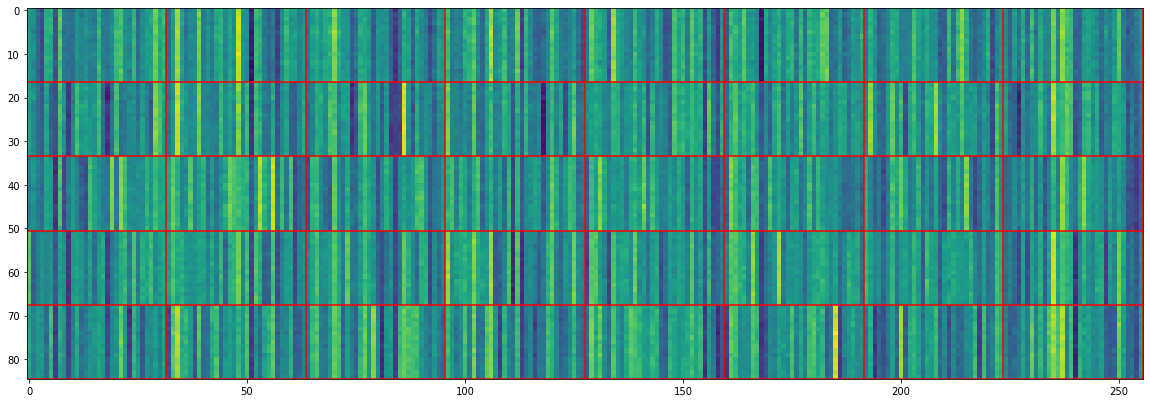

In [122]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

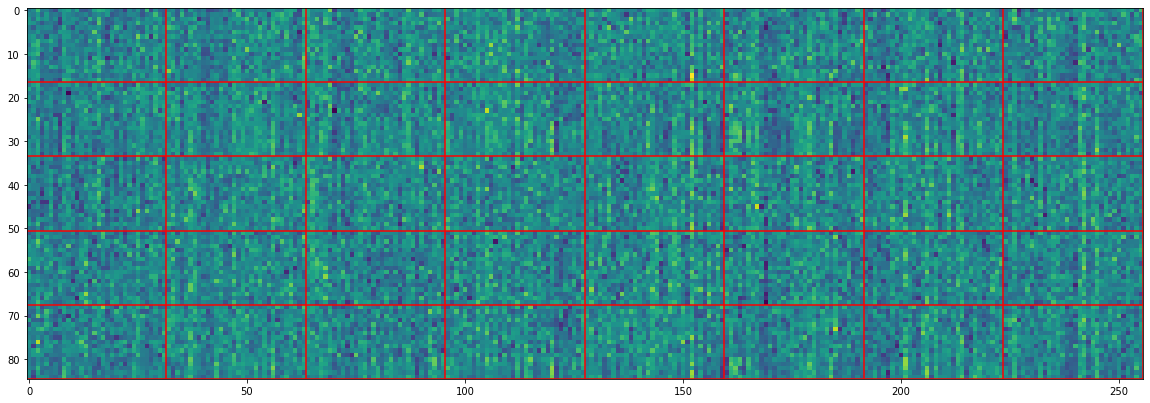

In [123]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    h.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

In [124]:
# Decoder Block 6

## prev는 search를 위한 것
batch_size, m = h.size()[:-1]
fwd_mask = torch.triu(h.new_ones((m, m)), diagonal=1).bool()
fwd_mask = fwd_mask.unsqueeze(0).expand(batch_size, *fwd_mask.size())

## masked MultiHead-Attention
masked_Q_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_K_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_V_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_linear_6   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = h
mask = fwd_mask

QWs = masked_Q_linear_6(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = masked_K_linear_6(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = masked_V_linear_6(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
masked_w = torch.bmm(QWs, KWs.transpose(1, 2))
masked_w.masked_fill_(mask, -float('inf'))
masked_w = softmax(masked_w / (dk ** .5))
masked_c = torch.bmm(masked_w, VWs)

masked_c = masked_c.split(Q.size(0), dim=0)
masked_c = masked_linear_6(torch.cat(masked_c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
masked_attn_norm_6 = nn.LayerNorm(HIDDEN_SIZE)
masked_attn_dropout_6 = nn.Dropout(DROPOUT_P)

h = masked_attn_norm_6(h + masked_attn_dropout_6(masked_c))

## MultiHead-Attention
Q_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_6   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = h
V = K = key_and_value
mask = mask_dec

QWs = Q_linear_6(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_6(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_6(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_6(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_6 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_6= nn.Dropout(DROPOUT_P)

h = attn_norm_6(h + attn_dropout_6(c))

### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_6 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_6 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_6 = nn.Dropout(DROPOUT_P)

h = fc_norm_6(h + fc_dropout_6(fc_6(h)))

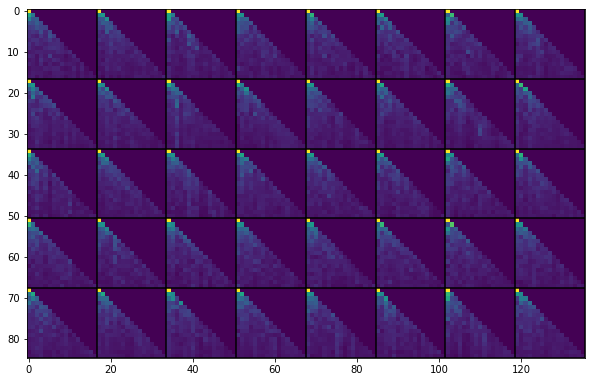

In [125]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(masked_w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(17*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

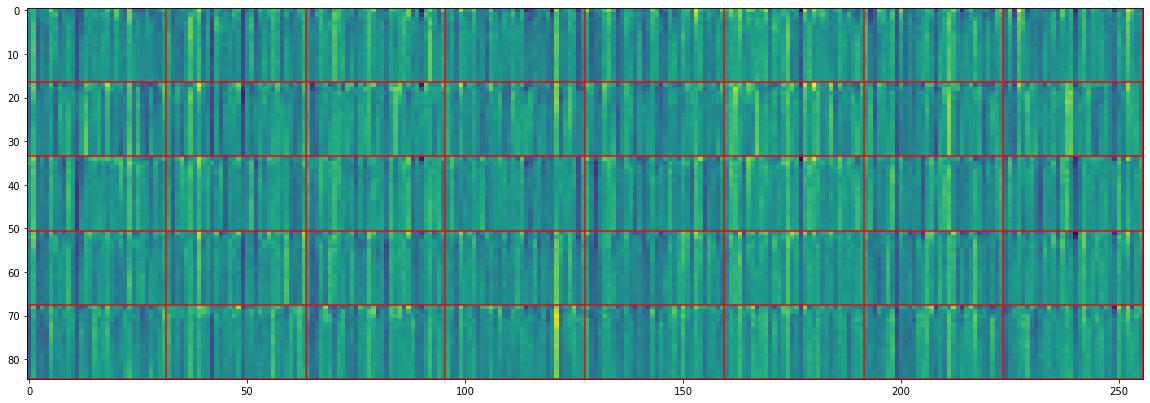

In [126]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    masked_c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

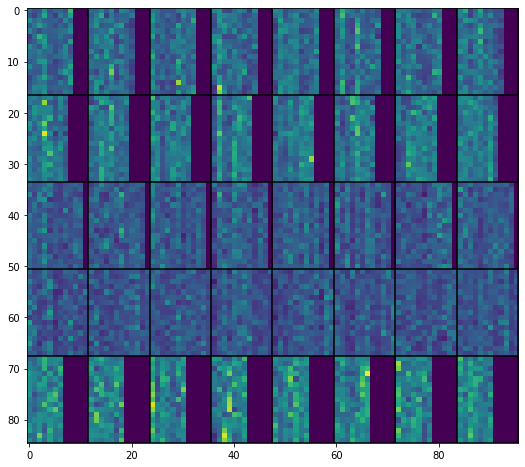

In [127]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

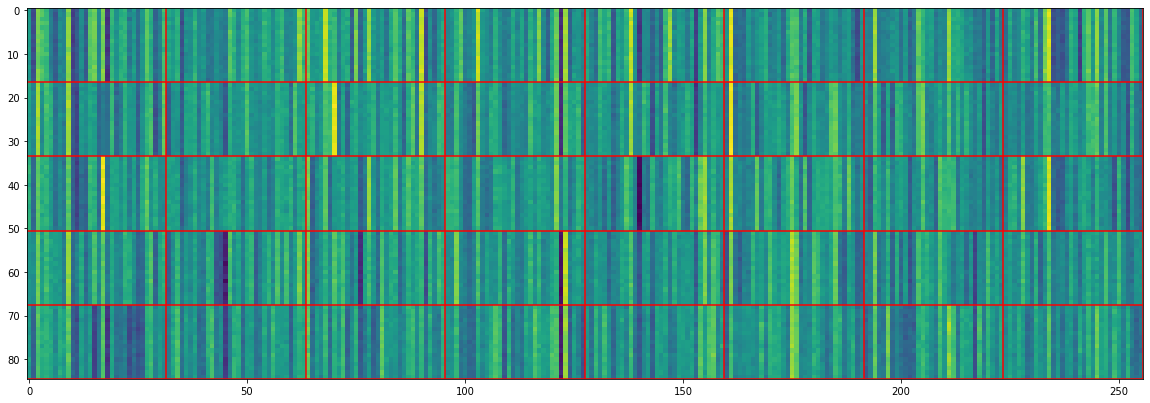

In [128]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

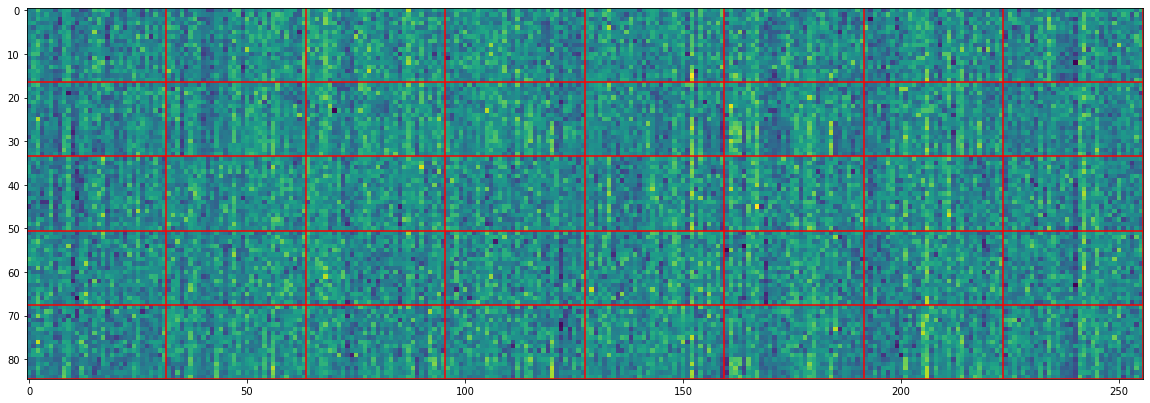

In [129]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    h.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

In [130]:
output = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
logsoftmax = nn.LogSoftmax(dim=-1)

In [131]:
y_pred = softmax(output(h))

In [132]:
y_pred.shape

torch.Size([5, 17, 34308])